# Federated Proximal (FedProx) - Non-IID Research Notebook

## 1. Library Imports & Configuration

**Eksperimen:** Network Intrusion Detection menggunakan FedProx pada TON_IoT Dataset  

**Distribusi Data:** Non-IID (Dirichlet) dengan Natural Class Imbalance  ---

**Framework:** Flower 1.24.0 + TensorFlow 2.20.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, 
    precision_score, recall_score, confusion_matrix
 )

import tensorflow as tf
import keras
from keras import backend as K

# Flower imports
import flwr as fl
from flwr.simulation import start_simulation
from flwr.server.strategy import FedProx

# Local imports - import directly from current directory
from task import get_model_by_type, ProximalModel
from utils import (
    split_data_non_iid_label,
    evaluate_model_metrics,
    prepare_client_configs,
    print_summary_table
)
import pickle
from tabulate import tabulate
from IPython.display import display, HTML
import warnings

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '42'

# ============================================================================
# KONFIGURASI EKSPERIMEN - UBAH DI SINI
# ============================================================================
NUM_ROUNDS = 20            # Jumlah putaran komunikasi federated learning
NUM_CLIENTS = 5         # Jumlah klien dalam sistem
LOCAL_EPOCHS = 1           # Jumlah epoch pelatihan lokal per klien per round
BATCH_SIZE_BINARY = 512 # Ukuran batch untuk model binary (optimized)
BATCH_SIZE_MULTI = 512    # Ukuran batch untuk model multi-class (optimized)
LEARNING_RATE = 0.0005       # Learning rate untuk optimizer
MU_BINARY = 0.01            # FedProx proximal term coefficient untuk binary
MU_MULTI = 0.01           # FedProx proximal term coefficient untuk multi-class (reduced 10x)
ALPHA_BINARY = 5         # Parameter alpha Dirichlet untuk data binary (Non-IID)
ALPHA_MULTI = 5         # Parameter alpha Dirichlet untuk data multi-class (Non-IID)
FRAMEWORK = "Flower (flwr)" # Framework yang digunakan
ALGORITHM = "Federated Proximal (FedProx)"  # Algoritma federated learning
DATA_DISTRIBUTION = "IID (Dirichlet) - Heterogen"   # Jenis distribusi data
#DATA_DISTRIBUTION = "Non-IID (Dirichlet) - Natural Imbalance"   # Jenis distribusi data
# ============================================================================

print("=== FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER ===")
print(f"Konfigurasi: {NUM_CLIENTS} Klien, {NUM_ROUNDS} Putaran, {LOCAL_EPOCHS} Local Epochs")
print(f"Proximal Term (mu) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print(f"Data Distribution: {DATA_DISTRIBUTION}")
print(f"NO SMOTE - Natural class distribution preserved for Non-IID learning")
print("Semua library berhasil diimpor.")
print(f"TensorFlow version: {tf.__version__}")
print(f"Flower version: {fl.__version__}")

2025-12-17 02:35:08.505403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


=== FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER ===
Konfigurasi: 5 Klien, 20 Putaran, 1 Local Epochs
Proximal Term (mu) - Binary: 0.01, Multi-class: 0.01
Data Distribution: Non-IID (Dirichlet) - Natural Imbalance
NO SMOTE - Natural class distribution preserved for Non-IID learning
Semua library berhasil diimpor.
TensorFlow version: 2.20.0
Flower version: 1.24.0


## 2. Data Loading (Deprecated - Commented Out)

> Lihat Section 3 untuk loading preprocessed data.

> **Note:** Raw data loading sudah tidak digunakan.  > Data sudah di-preprocess secara terpisah menggunakan GPU-optimized pipeline.  

In [2]:
# print("--- Memuat Dataset ---")
# try:
#     df = pd.read_csv(
#         "/home/elnoersan/Skripsi/Paper/NotebookTODO/train_test_network.csv"
#     )
#     print(f"Dataset berhasil dimuat. Shape: {df.shape}")
# except FileNotFoundError:
#     print("File dataset tidak ditemukan. Pastikan path benar.")
#     raise

## 3. Data Preparation - Load Preprocessed Data

**GPU-Optimized Preprocessing Pipeline (External)**

**Preprocessing dilakukan sekali di luar notebook** menggunakan:  
`/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/preprocessing_pipeline.py`

**Pipeline Steps:**
1. Smart Preprocessing (Protocol-aware missing value handling)
2. Train/Test Split (80/20 stratified)
3. OneHot Encoding (fit on train only)
4. Feature Selection (VarianceThreshold - GPU friendly)
5. Standardization (StandardScaler)

**Benefits:**
-  **5-10 menit → <5 detik** loading time
-  **No data leakage** (all transformers fit only on training data)
-  **Reproducible** (same preprocessing across all experiments)
-  **No SMOTE** (preserves natural Non-IID distribution)

- Multi-class: 35 features (VarianceThreshold selected)

**Output:**- Binary: 30 features (VarianceThreshold selected)

In [3]:
# # def smart_preprocess_toniot_inplace(df):
# #     """
# #     Preprocessing TON_IoT dataset yang mempertimbangkan
# #     karakteristik protocol-specific attributes.
# #     Tidak menyimpan ke file, return langsung.
# #     """
# #     print("="*70)
# #     print("SMART PREPROCESSING TON_IOT DATASET")
# #     print("="*70)
    
# #     # Copy untuk avoid modifying original
# #     df_clean = df.copy()
# #     df_clean.columns = df_clean.columns.str.strip()
    
# #     # Replace '-' dengan NaN
# #     df_clean.replace('-', np.nan, inplace=True)
# #     print(f"[1/6] Data loaded: {df_clean.shape}")
    
# #     # --- Protocol-Specific Handling ---
# #     print("[2/6] Identifying protocol types...")
    
# #     # Protocol indicators (binary flags)
# #     df_clean['has_dns'] = df_clean['dns_query'].notna().astype(int) if 'dns_query' in df_clean.columns else 0
# #     df_clean['has_http'] = df_clean['http_method'].notna().astype(int) if 'http_method' in df_clean.columns else 0
# #     df_clean['has_ssl'] = df_clean['ssl_version'].notna().astype(int) if 'ssl_version' in df_clean.columns else 0
    
# #     if 'dns_query' in df_clean.columns:
# #         print(f"  - DNS traffic: {df_clean['has_dns'].sum():,} records")
# #     if 'http_method' in df_clean.columns:
# #         print(f"  - HTTP traffic: {df_clean['has_http'].sum():,} records")
# #     if 'ssl_version' in df_clean.columns:
# #         print(f"  - SSL traffic: {df_clean['has_ssl'].sum():,} records")
    
# #     # --- Convert Numeric Columns ---
# #     print("[3/6] Converting numeric columns...")
# #     numeric_cols = {
# #         'connection': ['duration', 'src_bytes', 'dst_bytes', 'missed_bytes',
# #                       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes'],
# #         'dns': ['dns_qclass', 'dns_qtype', 'dns_rcode'],
# #         'http': ['http_trans_depth', 'http_request_body_len', 
# #                 'http_response_body_len', 'http_status_code']
# #     }
    
# #     all_numeric = numeric_cols['connection'] + numeric_cols['dns'] + numeric_cols['http']
# #     for col in all_numeric:
# #         if col in df_clean.columns:
# #             df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
# #     # --- Handle Missing Values (Context-Aware) ---
# #     print("[4/6] Handling missing values (context-aware)...")
    
# #     # Connection-level: fill with 0 (no transfer)
# #     for col in numeric_cols['connection']:
# #         if col in df_clean.columns:
# #             df_clean[col] = df_clean[col].fillna(0)
    
# #     # DNS-specific: fill with -1 for DNS traffic, 0 for non-DNS
# #     for col in numeric_cols['dns']:
# #         if col in df_clean.columns:
# #             mask_dns = df_clean['has_dns'] == 1
# #             df_clean.loc[mask_dns, col] = df_clean.loc[mask_dns, col].fillna(-1)
# #             df_clean[col] = df_clean[col].fillna(0)
    
# #     # HTTP-specific: fill with -1 for HTTP traffic, 0 for non-HTTP
# #     for col in numeric_cols['http']:
# #         if col in df_clean.columns:
# #             mask_http = df_clean['has_http'] == 1
# #             df_clean.loc[mask_http, col] = df_clean.loc[mask_http, col].fillna(-1)
# #             df_clean[col] = df_clean[col].fillna(0)
    
# #     # --- Handle Categorical ---
# #     print("[5/6] Handling categorical variables...")
# #     categorical_cols = ['proto', 'service', 'conn_state']
# #     for col in categorical_cols:
# #         if col in df_clean.columns:
# #             df_clean[col] = df_clean[col].fillna('unknown')
    
# #     # --- Feature Engineering ---
# #     print("[6/6] Feature engineering...")
    
# #     # Ratio features (avoid division by zero)
# #     if 'src_bytes' in df_clean.columns and 'dst_bytes' in df_clean.columns:
# #         df_clean['bytes_ratio'] = np.where(
# #             df_clean['dst_bytes'] > 0,
# #             df_clean['src_bytes'] / df_clean['dst_bytes'],
# #             0
# #         )
    
# #     if 'src_pkts' in df_clean.columns and 'dst_pkts' in df_clean.columns:
# #         df_clean['pkts_ratio'] = np.where(
# #             df_clean['dst_pkts'] > 0,
# #             df_clean['src_pkts'] / df_clean['dst_pkts'],
# #             0
# #         )
    
# #     # Rate features
# #     if 'src_bytes' in df_clean.columns and 'duration' in df_clean.columns:
# #         df_clean['src_bytes_rate'] = np.where(
# #             df_clean['duration'] > 0,
# #             df_clean['src_bytes'] / df_clean['duration'],
# #             0
# #         )
    
# #     if 'dst_bytes' in df_clean.columns and 'duration' in df_clean.columns:
# #         df_clean['dst_bytes_rate'] = np.where(
# #             df_clean['duration'] > 0,
# #             df_clean['dst_bytes'] / df_clean['duration'],
# #             0
# #         )
    
# #     print(f"\nPreprocessing completed!")
# #     print(f"  - Shape: {df_clean.shape}")
# #     print(f"  - Missing values: {df_clean.isnull().sum().sum()}")
# #     print(f"  - New features added: bytes_ratio, pkts_ratio, src_bytes_rate, dst_bytes_rate")
# #     print(f"  - Protocol indicators: has_dns, has_http, has_ssl")
# #     print("="*70)
    
# #     return df_clean

# # Apply smart preprocessing
# print("\n--- SMART PREPROCESSING ---")
# # df_preprocessed = smart_preprocess_toniot_inplace(df)
# df_preprocessed = df

# print("\n" + "="*70)
# print("PREPARASI DATA UNTUK DETEKSI BINER")
# print("="*70)
# df_binary = df_preprocessed.drop(columns=['src_ip','src_port','dst_ip','dst_port','type', 'weird_name','weird_addl','weird_notice'], errors='ignore')
# X_binary = df_binary.drop('label', axis=1)
# y_binary = df_binary['label']

# # CORRECT PIPELINE: Split FIRST, then encode (prevents data leakage)
# print("\n[Step 1] Split data train/test SEBELUM encoding...")
# X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
#     X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
# )
# print(f"  - Train: {X_train_bin.shape}")
# print(f"  - Test: {X_test_bin.shape}")

# # Identify categorical columns
# categorical_cols = X_train_bin.select_dtypes(include=['object']).columns.tolist()
# numeric_cols = X_train_bin.select_dtypes(exclude=['object']).columns.tolist()
# print(f"\n[Step 2] Encoding {len(categorical_cols)} categorical columns with OneHotEncoder...")
# print(f"  Categorical: {categorical_cols}")
# print(f"  Numeric (passthrough): {len(numeric_cols)} columns")

# # Debug: Check for unseen categories
# print(f"\n  DEBUG - Checking for unseen categories in test set:")
# for col in categorical_cols:
#     train_unique = set(X_train_bin[col].unique())
#     test_unique = set(X_test_bin[col].unique())
#     unseen = test_unique - train_unique
#     if unseen:
#         print(f"    - {col}: Unseen in test: {unseen} ({len(unseen)} values)")
#     else:
#         print(f"    - {col}: No unseen categories ✓")

# # OneHotEncoder with ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# if categorical_cols:
#     # Create preprocessor with OneHotEncoder
#     preprocessor_binary = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
#         ],
#         remainder='passthrough'  # Keep numeric columns as-is
#     )
    
#     # Fit on training data only
#     X_train_bin_encoded = preprocessor_binary.fit_transform(X_train_bin)
#     X_test_bin_encoded = preprocessor_binary.transform(X_test_bin)
    
#     print(f"\n✓ OneHotEncoding completed without data leakage")
#     print(f"  - Encoder fit ONLY on training data")
#     print(f"  - Test data transformed using training encoder")
#     print(f"  - Unseen categories handled gracefully (ignored)")
#     print(f"  - Train shape after encoding: {X_train_bin_encoded.shape}")
#     print(f"  - Test shape after encoding: {X_test_bin_encoded.shape}")
# else:
#     X_train_bin_encoded = X_train_bin.values
#     X_test_bin_encoded = X_test_bin.values
#     preprocessor_binary = None
#     print(f"\n✓ No categorical columns, using numeric data directly")

# print("\n[Step 3] Feature selection HANYA pada data training...")
# n_features_bin = min(30, X_train_bin_encoded.shape[1])
# rfe = RFE(
#     estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
#     n_features_to_select=n_features_bin
# )
# X_train_bin_selected = rfe.fit_transform(X_train_bin_encoded, y_train_bin)
# X_test_bin_selected = rfe.transform(X_test_bin_encoded)

# print(f"  - Selected features: {n_features_bin}/{X_train_bin_encoded.shape[1]}")

# print("\n[Step 4] Scale data - fit pada train, transform pada test...")
# scaler_binary = StandardScaler()
# X_train_bin_scaled = scaler_binary.fit_transform(X_train_bin_selected)
# X_test_bin_scaled = scaler_binary.transform(X_test_bin_selected)

# print(f"\n✓ Data biner siap (NO DATA LEAKAGE):")
# print(f"  - Train: {X_train_bin_scaled.shape}")
# print(f"  - Test: {X_test_bin_scaled.shape}")
# print(f"  - All preprocessing fit ONLY on training data")
# print("="*70)

# gc.collect()

# print("\n" + "="*70)
# print("PREPARASI DATA UNTUK KLASIFIKASI MULTI-KELAS")
# print("="*70)
# df_multi = df_preprocessed.drop(columns=['src_ip','src_port','dst_ip','dst_port', 'label', 'weird_name','weird_addl','weird_notice'], errors='ignore')
# y_multi = df_multi['type']
# X_multi = df_multi.drop('type', axis=1)

# # Encode target BEFORE split (safe - just label mapping)
# le_target = LabelEncoder()
# y_multi_encoded = le_target.fit_transform(y_multi)
# num_classes = len(le_target.classes_)
# print(f"Jumlah kelas: {num_classes}")
# print(f"Nama kelas: {list(le_target.classes_)}")

# # CORRECT PIPELINE FOR NON-IID FL: Split FIRST, then encode features
# print("\n[Step 1] Split data train/test SEBELUM encoding features...")
# X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
#     X_multi, y_multi_encoded, test_size=0.2, random_state=42, stratify=y_multi_encoded
# )
# print(f"  - Train: {X_train_multi.shape}")
# print(f"  - Test: {X_test_multi.shape}")

# # Display class distribution (natural imbalance)
# print("\n✓ Distribusi kelas ASLI (Training Data - Natural Imbalance):")
# unique, counts = np.unique(y_train_multi, return_counts=True)
# class_dist = dict(zip(unique, counts))
# for class_idx, count in sorted(class_dist.items()):
#     class_name = le_target.classes_[class_idx]
#     pct = (count / len(y_train_multi)) * 100
#     print(f"   - {class_name}: {count:,} sampel ({pct:.2f}%)")
# print(f"   TOTAL: {len(y_train_multi):,} sampel")

# print("\n⚠ CATATAN: SMOTE TIDAK DIGUNAKAN untuk Federated Learning Non-IID")
# print("Alasan:")
# print("  1. SMOTE menghilangkan heterogenitas data (tujuan Non-IID)")
# print("  2. FedProx dirancang untuk data imbalanced natural")
# print("  3. Real-world: MITM jarang, model belajar dari distribusi asli")
# print("  4. Proximal term (mu) menangani heterogenitas tanpa sintetis")

# # Identify categorical columns
# categorical_cols_multi = X_train_multi.select_dtypes(include=['object']).columns.tolist()
# numeric_cols_multi = X_train_multi.select_dtypes(exclude=['object']).columns.tolist()
# print(f"\n[Step 2] Encoding {len(categorical_cols_multi)} categorical columns with OneHotEncoder...")
# print(f"  Categorical: {categorical_cols_multi}")
# print(f"  Numeric (passthrough): {len(numeric_cols_multi)} columns")

# # Debug: Check for unseen categories
# print(f"\n  DEBUG - Checking for unseen categories in test set:")
# for col in categorical_cols_multi:
#     train_unique = set(X_train_multi[col].unique())
#     test_unique = set(X_test_multi[col].unique())
#     unseen = test_unique - train_unique
#     if unseen:
#         print(f"    - {col}: Unseen in test: {unseen} ({len(unseen)} values)")
#     else:
#         print(f"    - {col}: No unseen categories ✓")

# # OneHotEncoder with ColumnTransformer
# if categorical_cols_multi:
#     # Create preprocessor with OneHotEncoder
#     preprocessor_multi = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols_multi)
#         ],
#         remainder='passthrough'  # Keep numeric columns as-is
#     )
    
#     # Fit on training data only
#     X_train_multi_encoded = preprocessor_multi.fit_transform(X_train_multi)
#     X_test_multi_encoded = preprocessor_multi.transform(X_test_multi)
    
#     print(f"\n✓ OneHotEncoding completed without data leakage")
#     print(f"  - Encoder fit ONLY on training data")
#     print(f"  - Test data transformed using training encoder")
#     print(f"  - Unseen categories handled gracefully (ignored)")
#     print(f"  - Train shape after encoding: {X_train_multi_encoded.shape}")
#     print(f"  - Test shape after encoding: {X_test_multi_encoded.shape}")
# else:
#     X_train_multi_encoded = X_train_multi.values
#     X_test_multi_encoded = X_test_multi.values
#     preprocessor_multi = None
#     print(f"\n✓ No categorical columns, using numeric data directly")

# print("\n[Step 3] Feature selection HANYA pada data training...")
# n_features_multi = min(35, X_train_multi_encoded.shape[1])
# rfe_multi = RFE(
#     estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), 
#     n_features_to_select=n_features_multi
# )
# X_train_multi_scaled_features = rfe_multi.fit_transform(X_train_multi_encoded, y_train_multi)
# X_test_multi_scaled_features = rfe_multi.transform(X_test_multi_encoded)

# print(f"  - Selected features: {n_features_multi}/{X_train_multi_encoded.shape[1]}")

# print("\n[Step 4] Scale data - fit pada train, transform pada test...")
# scaler_multi = StandardScaler()
# X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi_scaled_features)
# X_test_multi_scaled = scaler_multi.transform(X_test_multi_scaled_features)

# print(f"\n✓ Data multi-kelas siap (NO DATA LEAKAGE):")
# print(f"  - Train: {X_train_multi_scaled.shape} (natural distribution)")
# print(f"  - Test: {X_test_multi_scaled.shape}")
# print(f"  - All preprocessing fit ONLY on training data")
# print("="*70)

# # Save preprocessors for production use (ONLY trained on training data)
# preprocessors = {
#     'binary': {
#         'preprocessor': preprocessor_binary,
#         'rfe': rfe,
#         'scaler': scaler_binary,
#         'categorical_columns': categorical_cols,
#         'numeric_columns': numeric_cols
#     },
#     'multi': {
#         'preprocessor': preprocessor_multi,
#         'target_encoder': le_target,
#         'rfe': rfe_multi,
#         'scaler': scaler_multi,
#         'categorical_columns': categorical_cols_multi,
#         'numeric_columns': numeric_cols_multi,
#         'num_classes': num_classes
#     }
# }

# with open('preprocessors.pkl', 'wb') as f:
#     pickle.dump(preprocessors, f)
# print("\n✓ Preprocessors saved to 'preprocessors.pkl'")
# print("  - All preprocessors fit ONLY on training data (no leakage)")
# print("  - OneHotEncoder handles unseen categories with 'ignore'")
# print("  - Ready for production use with unseen data handling")

# gc.collect()

# NOPE WE FOUND FAST METHOD JUST LOAD THE PICKLE using existing /home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/processed_artifacts/binary_preprocessed.pkl
#/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/processed_artifacts/multiclass_preprocessed.pkl

#Let this comment exitsed i dont trust git commit

In [4]:
print("="*70)
print("LOAD PREPROCESSED DATA (GPU-OPTIMIZED)")
print("="*70)

# Load binary classification data
print("\n[1/2] Loading binary classification data...")
with open('/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/processed_artifacts/binary_preprocessed.pkl', 'rb') as f:
    binary_data = pickle.load(f)

X_train_bin_scaled = binary_data['X_train']
X_test_bin_scaled = binary_data['X_test']
y_train_bin = binary_data['y_train']
y_test_bin = binary_data['y_test']

print(f"✓ Binary data loaded:")
print(f"  - Train: {X_train_bin_scaled.shape}")
print(f"  - Test: {X_test_bin_scaled.shape}")
print(f"  - Features: {binary_data.get('metadata', {}).get('n_features_final', 'N/A')}")

# Load multi-class classification data
print("\n[2/2] Loading multi-class classification data...")
with open('/home/elnoersan/Skripsi/Paper/NotebookTODO/EDA/processed_artifacts/multiclass_preprocessed.pkl', 'rb') as f:
    multi_data = pickle.load(f)

X_train_multi_scaled = multi_data['X_train']
X_test_multi_scaled = multi_data['X_test']
y_train_multi = multi_data['y_train']
y_test_multi = multi_data['y_test']
num_classes = multi_data['num_classes']
class_names = multi_data['class_names']  # ✅ Load from pickle!
le_target = multi_data['target_encoder']  # ✅ Load LabelEncoder from pickle!

print(f"✓ Multi-class data loaded:")
print(f"  - Train: {X_train_multi_scaled.shape}")
print(f"  - Test: {X_test_multi_scaled.shape}")
print(f"  - Classes: {num_classes}")
print(f"  - Class names: {class_names}")
print(f"  - Features: {multi_data.get('metadata', {}).get('n_features_final', 'N/A')}")

print("\n" + "="*70)
print("DATA READY FOR TRAINING!")
print("="*70)
print("✓ No data leakage (preprocessed separately)")
print("✓ Train/test split done before encoding")
print("✓ All transformers fit only on training data")
print(f"✓ Time saved: ~5-10 minutes → <5 seconds")
print("="*70)

gc.collect()


LOAD PREPROCESSED DATA (GPU-OPTIMIZED)

[1/2] Loading binary classification data...
✓ Binary data loaded:
  - Train: (168834, 34)
  - Test: (42209, 34)
  - Features: 34

[2/2] Loading multi-class classification data...
✓ Multi-class data loaded:
  - Train: (168834, 34)
  - Test: (42209, 34)
  - Classes: 10
  - Class names: ['backdoor', 'ddos', 'dos', 'injection', 'mitm', 'normal', 'password', 'ransomware', 'scanning', 'xss']
  - Features: 34

DATA READY FOR TRAINING!
✓ No data leakage (preprocessed separately)
✓ Train/test split done before encoding
✓ All transformers fit only on training data
✓ Time saved: ~5-10 minutes → <5 seconds


0

## BAGIAN 4: SPLIT DATA KE KLIEN (NON-IID)

Bagian ini akan:
1. Mendistribusikan data training ke klien dengan pola Non-IID
2. Menampilkan statistik distribusi per klien
3. Memvisualisasikan heterogenitas data

In [5]:
print("="*70)
print("DISTRIBUSI DATA KE KLIEN - NON-IID")
print("="*70)

# Split data untuk klien menggunakan konfigurasi alpha yang sudah didefinisikan
print("\n[1/2] Splitting Binary data dengan Dirichlet distribution...")
print(f"      Alpha = {ALPHA_BINARY} (lower = more heterogeneous)")
client_data_binary = split_data_non_iid_label(
    X_train_bin_scaled, 
    y_train_bin, 
    n_clients=NUM_CLIENTS, 
    alpha=ALPHA_BINARY
)

print("\n[2/2] Splitting Multi-class data dengan Dirichlet distribution...")
print(f"      Alpha = {ALPHA_MULTI} (lower = more heterogeneous)")
client_data_multi = split_data_non_iid_label(
    X_train_multi_scaled, 
    y_train_multi, 
    n_clients=NUM_CLIENTS, 
    alpha=ALPHA_MULTI
)

print("\n" + "="*70)
print("SUMMARY - DATA SPLIT COMPLETED")
print("="*70)
print(f"Binary Test Set: {X_test_bin_scaled.shape}")
print(f"Multi-class Test Set: {X_test_multi_scaled.shape}")
print(f"\nTraining data dengan NATURAL DISTRIBUTION telah didistribusikan")
print(f"  - Jumlah Klien: {NUM_CLIENTS}")
print(f"  - Distribution: Non-IID (Dirichlet)")
print(f"  - NO SMOTE: Natural heterogeneity preserved")
print(f"  - FedProx akan menangani data imbalance secara natural")
print("="*70)

DISTRIBUSI DATA KE KLIEN - NON-IID

[1/2] Splitting Binary data dengan Dirichlet distribution...
      Alpha = 5 (lower = more heterogeneous)

[INFO] Splitting data for 5 clients with Non-IID (alpha=5)...
    Client 1: 18363 samples, distribution: {np.int64(0): np.int64(9011), np.int64(1): np.int64(9352)}
    Client 2: 52347 samples, distribution: {np.int64(0): np.int64(12919), np.int64(1): np.int64(39428)}
    Client 3: 42125 samples, distribution: {np.int64(0): np.int64(6591), np.int64(1): np.int64(35534)}
    Client 4: 34395 samples, distribution: {np.int64(0): np.int64(6444), np.int64(1): np.int64(27951)}
    Client 5: 21604 samples, distribution: {np.int64(0): np.int64(5035), np.int64(1): np.int64(16569)}

[2/2] Splitting Multi-class data dengan Dirichlet distribution...
      Alpha = 5 (lower = more heterogeneous)

[INFO] Splitting data for 5 clients with Non-IID (alpha=5)...
    Client 1: 41509 samples, distribution: {np.int64(0): np.int64(2641), np.int64(1): np.int64(5101), np.

### 4.2 DISTRIBUSI BINARY DATA PER KLIE

In [6]:
print("\n" + "="*70)
print("DISTRIBUSI BINARY DATA PER KLIEN")
print("="*70)

binary_dist_data = []
total_samples = 0

for i, (X_client, y_client) in enumerate(client_data_binary):
    n_samples = len(X_client)
    n_normal = np.sum(y_client == 0)
    n_attack = np.sum(y_client == 1)
    pct_normal = (n_normal / n_samples) * 100
    pct_attack = (n_attack / n_samples) * 100
    
    binary_dist_data.append([
        f"Client {i+1}",
        f"{n_samples:,}",
        f"{n_normal:,}",
        f"{pct_normal:.1f}%",
        f"{n_attack:,}",
        f"{pct_attack:.1f}%"
    ])
    total_samples += n_samples

# Add total row
binary_dist_data.append([
    "TOTAL",
    f"{total_samples:,}",
    f"{np.sum([np.sum(y == 0) for _, y in client_data_binary]):,}",
    "-",
    f"{np.sum([np.sum(y == 1) for _, y in client_data_binary]):,}",
    "-"
])

headers = ["Client", "Total Samples", "Normal", "Normal %", "Attack", "Attack %"]
print("\n" + tabulate(binary_dist_data, headers=headers, tablefmt="grid"))

# Calculate heterogeneity metric
print("\nHETEROGENEITY METRICS:")
attack_ratios = [(np.sum(y == 1) / len(y)) for _, y in client_data_binary]
print(f"  - Attack ratio range: {min(attack_ratios):.3f} - {max(attack_ratios):.3f}")
print(f"  - Attack ratio std dev: {np.std(attack_ratios):.3f}")
print(f"  - Higher std dev = more heterogeneous (good for Non-IID)")
print("="*70)


DISTRIBUSI BINARY DATA PER KLIEN

+----------+-----------------+----------+------------+----------+------------+
| Client   | Total Samples   | Normal   | Normal %   | Attack   | Attack %   |
+==========+=================+==========+============+==========+============+
| Client 1 | 18,363          | 9,011    | 49.1%      | 9,352    | 50.9%      |
+----------+-----------------+----------+------------+----------+------------+
| Client 2 | 52,347          | 12,919   | 24.7%      | 39,428   | 75.3%      |
+----------+-----------------+----------+------------+----------+------------+
| Client 3 | 42,125          | 6,591    | 15.6%      | 35,534   | 84.4%      |
+----------+-----------------+----------+------------+----------+------------+
| Client 4 | 34,395          | 6,444    | 18.7%      | 27,951   | 81.3%      |
+----------+-----------------+----------+------------+----------+------------+
| Client 5 | 21,604          | 5,035    | 23.3%      | 16,569   | 76.7%      |
+----------+-----

### 4.3 DISTRIBUSI MULTI-CLASS DATA PER KLIE

In [7]:
print("="*70)
print("DISTRIBUSI MULTI-CLASS DATA PER KLIEN")
print("="*70)

# Get class names
class_names = le_target.classes_

# Build distribution table
multi_dist_data = []
for i, (X_client, y_client) in enumerate(client_data_multi):
    row = [f"Client {i+1}", f"{len(X_client):,}"]
    
    for class_idx in range(num_classes):
        count = np.sum(y_client == class_idx)
        row.append(f"{count:,}")
    
    multi_dist_data.append(row)

# Add total row
total_row = ["TOTAL", f"{sum([len(X) for X, _ in client_data_multi]):,}"]
for class_idx in range(num_classes):
    total_count = sum([np.sum(y == class_idx) for _, y in client_data_multi])
    total_row.append(f"{total_count:,}")
multi_dist_data.append(total_row)

headers = ["Client", "Total"] + [name for name in class_names]
print("\n" + tabulate(multi_dist_data, headers=headers, tablefmt="grid"))

# Calculate per-class distribution across clients
print("\nCLASS DISTRIBUTION ANALYSIS:")
for class_idx, class_name in enumerate(class_names):
    counts_per_client = [np.sum(y == class_idx) for _, y in client_data_multi]
    print(f"\n  {class_name}:")
    print(f"    - Total: {sum(counts_per_client):,} samples")
    print(f"    - Per client: {counts_per_client}")
    print(f"    - Std dev: {np.std(counts_per_client):.1f} (higher = more heterogeneous)")

print("="*70)

DISTRIBUSI MULTI-CLASS DATA PER KLIEN

+----------+---------+------------+--------+--------+-------------+--------+----------+------------+--------------+------------+--------+
| Client   | Total   | backdoor   | ddos   | dos    | injection   |   mitm | normal   | password   | ransomware   | scanning   | xss    |
+==========+=========+============+========+========+=============+========+==========+============+==============+============+========+
| Client 1 | 41,509  | 2,641      | 5,101  | 3,172  | 3,772       |    149 | 11,514   | 2,902      | 4,272        | 5,748      | 2,238  |
+----------+---------+------------+--------+--------+-------------+--------+----------+------------+--------------+------------+--------+
| Client 2 | 31,124  | 1,901      | 3,954  | 2,692  | 1,485       |    156 | 9,688    | 4,900      | 1,608        | 2,448      | 2,292  |
+----------+---------+------------+--------+--------+-------------+--------+----------+------------+--------------+------------+-----

## BAGIAN 5: DEFINISI FUNGSI UNTUK FLOWER CLIENT DENGAN FEDPROX

In [8]:
class FlowerClientProx(fl.client.NumPyClient):
    """Flower client untuk federated learning dengan FedProx."""
    
    def __init__(self, client_id, X_train, y_train, X_test, y_test, 
                 model_type, input_shape, num_classes, config):
        self.client_id = client_id
        self.X_train = X_train.astype(np.float32)
        self.y_train = y_train
        self.X_test = X_test.astype(np.float32) if X_test is not None else None
        self.y_test = y_test
        self.model_type = model_type
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.config = config
        
        # Untuk CNN, reshape input
        if 'cnn' in model_type:
            self.X_train = self.X_train.reshape(-1, input_shape, 1)
            if self.X_test is not None:
                self.X_test = self.X_test.reshape(-1, input_shape, 1)
    
    def get_parameters(self, config):
        """Return model parameters."""
        K.clear_session()
        temp_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        weights = temp_model.get_weights()
        del temp_model
        K.clear_session()
        return weights
    
    def set_parameters(self, parameters):
        """Set model parameters - not used in this implementation."""
        pass
    
    def fit(self, parameters, config):
        """Train model on local data using FedProx.
        
        The server sends 'proximal_mu' in the config dictionary.
        """
        # Clear previous session state
        K.clear_session()
        
        # Get proximal_mu from server config (sent by FedProx strategy)
        proximal_mu = config.get('proximal_mu', 0.01)
        
        # Create base model and set global weights
        base_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        base_model.set_weights(parameters)
        
        # Wrap with ProximalModel (parameters are the global weights for proximal term)
        proximal_model = ProximalModel(
            base_model, 
            parameters, 
            proximal_mu  # Use mu from server config
        )
        
        # Compile proximal model
        loss_fn = 'binary_crossentropy' if self.num_classes == 1 else 'sparse_categorical_crossentropy'
        proximal_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.config['learning_rate']),
            loss=loss_fn,
            metrics=['accuracy']
        )
        
        # Train with proximal term
        history = proximal_model.fit(
            self.X_train, self.y_train,
            epochs=self.config['local_epochs'],
            batch_size=self.config['batch_size'],
            verbose=0
        )
        
        # Extract updated weights from the base model (not wrapper)
        updated_weights = proximal_model.model.get_weights()
        
        # Prepare metrics
        metrics = {
            "train_loss": history.history['loss'][-1],
            "train_acc": history.history['accuracy'][-1]
        }
        
        # Clean up
        del base_model
        del proximal_model
        K.clear_session()
        
        return updated_weights, len(self.X_train), metrics
    
    def evaluate(self, parameters, config):
        """Evaluate model on local test data."""
        if self.X_test is None:
            return 0.0, 0, {}
        
        # Clear session and create fresh model for evaluation
        K.clear_session()
        
        eval_model = get_model_by_type(
            self.model_type, self.input_shape, 
            self.num_classes, self.config['learning_rate']
        )
        eval_model.set_weights(parameters)
        
        loss, accuracy = eval_model.evaluate(
            self.X_test, self.y_test, 
            batch_size=self.config['batch_size'], 
            verbose=0
        )
        
        # Clean up
        del eval_model
        K.clear_session()
        
        return loss, len(self.X_test), {"eval_acc": accuracy}


def create_client_fn_prox(client_data, test_data, model_type, input_shape, num_classes, config):
    """Factory function to create Flower clients with FedProx."""
    X_test, y_test = test_data
    
    def client_fn(cid: str) -> FlowerClientProx:
        client_id = int(cid)
        X_train, y_train = client_data[client_id]
        
        return FlowerClientProx(
            client_id, X_train, y_train, X_test, y_test,
            model_type, input_shape, num_classes, config
        )
    
    return client_fn

print("✅ Flower FedProx client class dan factory function didefinisikan")

✅ Flower FedProx client class dan factory function didefinisikan


## BAGIAN 6: FUNGSI PELATIHAN FEDERATED DENGAN FEDPROX

In [9]:
def run_federated_learning_fedprox(
    client_data,
    test_data,
    model_type,
    input_shape,
    num_classes,
    num_rounds=5,
    num_clients=3,
    local_epochs=1,
    batch_size=256,
    learning_rate=0.001,
    mu=0.01,
    fraction_fit=1.0,
    fraction_evaluate=1.0
):
    """Run federated learning using Flower simulation with FedProx.
    
    Args:
        client_data: List of (X, y) tuples for each client
        test_data: Tuple of (X_test, y_test) for evaluation
        model_type: Type of model to use
        input_shape: Number of input features
        num_classes: Number of output classes
        num_rounds: Number of federated rounds
        num_clients: Number of clients
        local_epochs: Epochs per client per round
        batch_size: Batch size for training
        learning_rate: Learning rate
        mu: FedProx proximal term coefficient
        fraction_fit: Fraction of clients for training
        fraction_evaluate: Fraction of clients for evaluation
        
    Returns:
        Tuple of (final_model, history)
    """
    print(f"\n[INFO] Starting Flower FedProx federated learning for {model_type}...")
    print(f"   Clients: {num_clients} | Rounds: {num_rounds} | Local epochs: {local_epochs}")
    print(f"   Proximal term (μ): {mu}")
    
    # Configuration
    config = {
        'local_epochs': local_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
    }
    
    # Create client factory
    client_fn = create_client_fn_prox(
        client_data, test_data, model_type, 
        input_shape, num_classes, config
    )
    
    # Create initial model to get parameters
    initial_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    initial_parameters = fl.common.ndarrays_to_parameters(initial_model.get_weights())
    
    # Define strategy with custom aggregation
    final_weights = [None]
    history_dict = {
        'train_accuracy': [],
        'train_loss': [],
        'eval_accuracy': [],
        'eval_loss': [],
        'round_time': [],
        'total_time': 0
    }
    
    round_start_time = [time.time()]
    
    # Use FedProx strategy from Flower (imported at top-level)
    
    class FedProxWithMetrics(FedProx):
        def aggregate_fit(self, server_round, results, failures):
            round_time = time.time() - round_start_time[0]
            history_dict['round_time'].append(round_time)
            
            aggregated_result = super().aggregate_fit(server_round, results, failures)
            if aggregated_result is not None:
                final_weights[0] = aggregated_result[0]
                
                if results:
                    train_losses = [fit_res.metrics.get('train_loss', 0) for _, fit_res in results if 'train_loss' in fit_res.metrics]
                    train_accs = [fit_res.metrics.get('train_acc', 0) for _, fit_res in results if 'train_acc' in fit_res.metrics]
                    
                    if train_losses:
                        avg_loss = np.mean(train_losses)
                        history_dict['train_loss'].append(avg_loss)
                        print(f"      Round {server_round} - Avg Train Loss: {avg_loss:.4f}")
                    
                    if train_accs:
                        avg_acc = np.mean(train_accs)
                        history_dict['train_accuracy'].append(avg_acc)
                        print(f"      Round {server_round} - Avg Train Acc: {avg_acc:.4f} - Time: {round_time:.2f}s")
            
            round_start_time[0] = time.time()
            return aggregated_result
        
        def aggregate_evaluate(self, server_round, results, failures):
            aggregated_result = super().aggregate_evaluate(server_round, results, failures)
            
            if results:
                eval_losses = [eval_res.loss for _, eval_res in results]
                eval_accs = [eval_res.metrics.get('eval_acc', 0) for _, eval_res in results if 'eval_acc' in eval_res.metrics]
                
                if eval_losses:
                    avg_eval_loss = np.mean(eval_losses)
                    history_dict['eval_loss'].append(avg_eval_loss)
                
                if eval_accs:
                    avg_eval_acc = np.mean(eval_accs)
                    history_dict['eval_accuracy'].append(avg_eval_acc)
            
            return aggregated_result
    
    strategy = FedProxWithMetrics(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=max(2, int(num_clients * fraction_fit)),
        min_evaluate_clients=max(2, int(num_clients * fraction_evaluate)),
        min_available_clients=num_clients,
        initial_parameters=initial_parameters,
        proximal_mu=mu,  # FedProx-specific parameter
    )
    
    # Start simulation
    start_time = time.time()
    
    history = start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        config=fl.server.ServerConfig(num_rounds=num_rounds),
        strategy=strategy,
    )
    
    total_time = time.time() - start_time
    history_dict['total_time'] = total_time
    
    # Get final model
    final_model = get_model_by_type(model_type, input_shape, num_classes, learning_rate)
    
    if final_weights[0] is not None:
        parameters = fl.common.parameters_to_ndarrays(final_weights[0])
        final_model.set_weights(parameters)
        print(f"   ✓ Model weights updated from FedProx training")
    else:
        print(f"   ⚠ Warning: Using initial model weights")
    
    print(f"\nFedProx federated learning completed in {total_time:.2f}s")
    print(f"   Captured {len(history_dict['train_accuracy'])} rounds of training metrics")
    print(f"   Avg time per round: {np.mean(history_dict['round_time']):.2f}s")
    
    return final_model, history_dict

print("Fungsi federated learning FedProx didefinisikan")

Fungsi federated learning FedProx didefinisikan


## BAGIAN 7: PELATIHAN SEMUA MODEL DENGAN FEDPROX

In [10]:
print("\n" + "="*70)
print("MEMULAI PELATIHAN FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER")
print(f"Proximal Term (μ) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print("="*70)

all_models = {}
all_histories = {}
all_metrics = {}

# Training Binary Models
print("\n--- PELATIHAN DETEKSI BINER DENGAN FEDPROX ---")

print("\nMelatih Model MLP Binary...")
all_models['mlp_binary'], all_histories['mlp_binary'] = run_federated_learning_fedprox(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'mlp_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE,
    mu=MU_BINARY
)

print("\nMelatih Model CNN Binary...")
all_models['cnn_binary'], all_histories['cnn_binary'] = run_federated_learning_fedprox(
    client_data_binary,
    (X_test_bin_scaled, y_test_bin),
    'cnn_binary',
    X_train_bin_scaled.shape[1],
    1,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_BINARY,
    learning_rate=LEARNING_RATE,
    mu=MU_BINARY
)

# Training Multi-class Models
print("\n--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FEDPROX ---")

print("\nMelatih Model MLP Multi-class...")
all_models['mlp_multi'], all_histories['mlp_multi'] = run_federated_learning_fedprox(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'mlp_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE,
    mu=MU_MULTI
)

print("\n Melatih Model CNN Multi-class...")
all_models['cnn_multi'], all_histories['cnn_multi'] = run_federated_learning_fedprox(
    client_data_multi,
    (X_test_multi_scaled, y_test_multi),
    'cnn_multi',
    X_train_multi_scaled.shape[1],
    num_classes,
    num_rounds=NUM_ROUNDS,
    num_clients=NUM_CLIENTS,
    local_epochs=LOCAL_EPOCHS,
    batch_size=BATCH_SIZE_MULTI,
    learning_rate=LEARNING_RATE,
    mu=MU_MULTI
)

print("\nSemua model berhasil dilatih dengan FedProx!")


MEMULAI PELATIHAN FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER
Proximal Term (μ) - Binary: 0.01, Multi-class: 0.01

--- PELATIHAN DETEKSI BINER DENGAN FEDPROX ---

Melatih Model MLP Binary...

[INFO] Starting Flower FedProx federated learning for mlp_binary...
   Clients: 5 | Rounds: 20 | Local epochs: 1
   Proximal term (μ): 0.01


/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765913711.289869  917371 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2103 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :  

      Round 1 - Avg Train Loss: 0.7093
      Round 1 - Avg Train Acc: 0.8837 - Time: 9.60s


(ClientAppActor pid=918151) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=918151)   return np.array(x)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      agg

      Round 2 - Avg Train Loss: 0.7389
      Round 2 - Avg Train Acc: 0.9447 - Time: 3.55s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918152) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To 

      Round 3 - Avg Train Loss: 0.7385
      Round 3 - Avg Train Acc: 0.9471 - Time: 3.65s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]


      Round 4 - Avg Train Loss: 0.7387
      Round 4 - Avg Train Acc: 0.9468 - Time: 3.65s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         


      Round 5 - Avg Train Loss: 0.7393
      Round 5 - Avg Train Acc: 0.9476 - Time: 3.72s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]


      Round 6 - Avg Train Loss: 0.7391
      Round 6 - Avg Train Acc: 0.9476 - Time: 3.70s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(pid=gcs_server) [2025-12-17 02:35:41,985 E 917983 917983] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-12-17 02:35:43,463 E 918099 918099] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Runn

      Round 7 - Avg Train Loss: 0.7385
      Round 7 - Avg Train Acc: 0.9489 - Time: 3.83s


(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918147) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'ci

      Round 8 - Avg Train Loss: 0.7396
      Round 8 - Avg Train Acc: 0.9491 - Time: 4.24s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918148) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]


      Round 9 - Avg Train Loss: 0.7390
      Round 9 - Avg Train Acc: 0.9499 - Time: 3.90s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         


      Round 10 - Avg Train Loss: 0.7389
      Round 10 - Avg Train Acc: 0.9507 - Time: 4.19s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918150) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=918150)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=918150)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=918152) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 11 - Avg Train Loss: 0.7391
      Round 11 - Avg Train Acc: 0.9514 - Time: 3.90s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]

      Round 12 - Avg Train Loss: 0.7387
      Round 12 - Avg Train Acc: 0.9518 - Time: 3.95s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         


      Round 13 - Avg Train Loss: 0.7392
      Round 13 - Avg Train Acc: 0.9519 - Time: 4.07s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=918151)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=918151)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=918151) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 14 - Avg Train Loss: 0.7386
      Round 14 - Avg Train Acc: 0.9527 - Time: 4.12s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]

      Round 15 - Avg Train Loss: 0.7383
      Round 15 - Avg Train Acc: 0.9524 - Time: 4.10s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         


      Round 16 - Avg Train Loss: 0.7389
      Round 16 - Avg Train Acc: 0.9520 - Time: 4.24s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918150) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=918150)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=918150)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=918150) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 17 - Avg Train Loss: 0.7387
      Round 17 - Avg Train Acc: 0.9521 - Time: 4.13s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]

      Round 18 - Avg Train Loss: 0.7392
      Round 18 - Avg Train Acc: 0.9520 - Time: 4.54s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918150) 
(ClientAppActor pid=918150)         
(ClientAppActor pid=918147) 
(ClientAppActor pid=918147)         
(ClientAppActor pid=918148) 
(ClientAppActor pid=918148)         
(ClientAppActor pid=918152) 
(ClientAppActor pid=918152)         


      Round 19 - Avg Train Loss: 0.7383
      Round 19 - Avg Train Acc: 0.9530 - Time: 4.58s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=918151) 
(ClientAppActor pid=918151)         
(ClientAppActor pid=918151) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=918151)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=918151)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=918151) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 20 - Avg Train Loss: 0.7395
      Round 20 - Avg Train Acc: 0.9522 - Time: 4.33s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 83.64s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4821513593196869
INFO :      		round 2: 0.3603875935077667
INFO :      		round 3: 0.3074842095375061
INFO :      		round 4: 0.2582322955131531
INFO :      		round 5: 0.22534552216529846
INFO :      		round 6: 0.2035638689994812
INFO :      		round 7: 0.18338273465633392
INFO :      		round 8: 0.17112721502780914
INFO :      		round 9: 0.15794537961483002
INFO :      		round 10: 0.15440033376216888
INFO :      		round 11: 0.15008458495140076
INFO :      		round 12: 0.1399606168270111
INFO :      		round 13: 0.13550977408885956
INFO :      		round 14: 0.13352520763874054
INFO :      		round 15: 0.12849023938179016
INFO :      		round 16: 0.12657664716243744
INFO :      		round 17: 0.12436268478631973
INFO :      		round 18: 0.12352447956800461
INFO :      		round 19: 0.1213710

   ✓ Model weights updated from FedProx training

FedProx federated learning completed in 87.38s
   Captured 20 rounds of training metrics
   Avg time per round: 4.30s

Melatih Model CNN Binary...

[INFO] Starting Flower FedProx federated learning for cnn_binary...
   Clients: 5 | Rounds: 20 | Local epochs: 1
   Proximal term (μ): 0.01


2025-12-17 02:36:42,394	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'object_store_memory': 13198644019.0, 'node:192.168.0.129': 1.0, 'node:__internal_head__': 1.0, 'CPU': 6.0, 'GPU': 1.0, 'memory': 30796836045.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929910) WARN

      Round 1 - Avg Train Loss: 0.7161
      Round 1 - Avg Train Acc: 0.8878 - Time: 13.54s


(ClientAppActor pid=929911) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=929911)   return np.array(x)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
INFO :      agg

      Round 2 - Avg Train Loss: 0.7368
      Round 2 - Avg Train Acc: 0.9456 - Time: 8.83s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929915) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 3 - Avg Train Loss: 0.7367
      Round 3 - Avg Train Acc: 0.9481 - Time: 7.51s


(pid=gcs_server) [2025-12-17 02:37:10,882 E 929781 929781] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(raylet) [2025-12-17 02:37:12,322 E 929863 929863] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Runn

      Round 4 - Avg Train Loss: 0.7365
      Round 4 - Avg Train Acc: 0.9494 - Time: 7.57s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929910) [2025-12-17 02:37:14,369 E 929910 930183] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 5x ac

      Round 5 - Avg Train Loss: 0.7368
      Round 5 - Avg Train Acc: 0.9497 - Time: 9.37s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 6 - Avg Train Loss: 0.7367
      Round 6 - Avg Train Acc: 0.9527 - Time: 9.31s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 7 - Avg Train Loss: 0.7370
      Round 7 - Avg Train Acc: 0.9560 - Time: 9.39s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929913) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 8 - Avg Train Loss: 0.7367
      Round 8 - Avg Train Acc: 0.9581 - Time: 9.00s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 9 - Avg Train Loss: 0.7370
      Round 9 - Avg Train Acc: 0.9606 - Time: 7.77s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 10 - Avg Train Loss: 0.7365
      Round 10 - Avg Train Acc: 0.9613 - Time: 7.82s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 11 - Avg Train Loss: 0.7370
      Round 11 - Avg Train Acc: 0.9617 - Time: 8.25s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 12 - Avg Train Loss: 0.7371
      Round 12 - Avg Train Acc: 0.9637 - Time: 9.26s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 13 - Avg Train Loss: 0.7375
      Round 13 - Avg Train Acc: 0.9639 - Time: 9.60s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 14 - Avg Train Loss: 0.7374
      Round 14 - Avg Train Acc: 0.9657 - Time: 9.72s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 15 - Avg Train Loss: 0.7374
      Round 15 - Avg Train Acc: 0.9641 - Time: 9.68s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929915) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 16 - Avg Train Loss: 0.7375
      Round 16 - Avg Train Acc: 0.9653 - Time: 9.81s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 17 - Avg Train Loss: 0.7382
      Round 17 - Avg Train Acc: 0.9660 - Time: 8.57s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 18 - Avg Train Loss: 0.7378
      Round 18 - Avg Train Acc: 0.9669 - Time: 9.51s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929911) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 19 - Avg Train Loss: 0.7381
      Round 19 - Avg Train Acc: 0.9677 - Time: 9.39s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929911) 
(ClientAppActor pid=929911)         
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929915) 
(ClientAppActor pid=929915)         
(ClientAppActor pid=929910) 
(ClientAppActor pid=929910)         
(ClientAppActor pid=929914) 
(ClientAppActor pid=929914)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=929913) 
(ClientAppActor pid=929913)         
(ClientAppActor pid=929913) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 20 - Avg Train Loss: 0.7381
      Round 20 - Avg Train Acc: 0.9667 - Time: 9.49s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 180.49s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5334079265594482
INFO :      		round 2: 0.3960685133934021
INFO :      		round 3: 0.28925779461860657
INFO :      		round 4: 0.2157638818025589
INFO :      		round 5: 0.1626773327589035
INFO :      		round 6: 0.14006617665290833
INFO :      		round 7: 0.11523423343896866
INFO :      		round 8: 0.11362849175930023
INFO :      		round 9: 0.10676652938127518
INFO :      		round 10: 0.09279338270425797
INFO :      		round 11: 0.08396967500448227
INFO :      		round 12: 0.09076033532619476
INFO :      		round 13: 0.08225460350513458
INFO :      		round 14: 0.0901743620634079
INFO :      		round 15: 0.07235196977853775
INFO :      		round 16: 0.07635080814361572
INFO :      		round 17: 0.07526029646396637
INFO :      		round 18: 0.07212982326745987
INFO :      		round 19: 0.07336

   ✓ Model weights updated from FedProx training

FedProx federated learning completed in 185.51s
   Captured 20 rounds of training metrics
   Avg time per round: 9.17s

--- PELATIHAN KLASIFIKASI MULTI-KELAS DENGAN FEDPROX ---

Melatih Model MLP Multi-class...

[INFO] Starting Flower FedProx federated learning for mlp_multi...
   Clients: 5 | Rounds: 20 | Local epochs: 1
   Proximal term (μ): 0.01


2025-12-17 02:39:48,027	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'object_store_memory': 13216319078.0, 'node:__internal_head__': 1.0, 'node:192.168.0.129': 1.0, 'CPU': 6.0, 'GPU': 1.0, 'memory': 30838077850.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) WARN

      Round 1 - Avg Train Loss: 0.1000
      Round 1 - Avg Train Acc: 0.5613 - Time: 10.91s


(ClientAppActor pid=942087) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=942087)   return np.array(x)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      agg

      Round 2 - Avg Train Loss: 0.1000
      Round 2 - Avg Train Acc: 0.6699 - Time: 5.58s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         


      Round 3 - Avg Train Loss: 0.1000
      Round 3 - Avg Train Acc: 0.6838 - Time: 4.65s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `C

      Round 4 - Avg Train Loss: 0.1000
      Round 4 - Avg Train Acc: 0.6899 - Time: 5.61s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `C

      Round 5 - Avg Train Loss: 0.1000
      Round 5 - Avg Train Acc: 0.6928 - Time: 5.57s


(raylet) [2025-12-17 02:40:17,951 E 942036 942036] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flow

      Round 6 - Avg Train Loss: 0.1000
      Round 6 - Avg Train Acc: 0.6959 - Time: 4.79s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]


      Round 7 - Avg Train Loss: 0.1000
      Round 7 - Avg Train Acc: 0.6971 - Time: 5.73s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
(ClientAppActor pid=942086) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 8 - Avg Train Loss: 0.1000
      Round 8 - Avg Train Acc: 0.6990 - Time: 5.74s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         


      Round 9 - Avg Train Loss: 0.1000
      Round 9 - Avg Train Acc: 0.7004 - Time: 4.77s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 10 - Avg Train Loss: 0.1000
      Round 10 - Avg Train Acc: 0.7019 - Time: 4.89s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]

      Round 11 - Avg Train Loss: 0.1000
      Round 11 - Avg Train Acc: 0.7014 - Time: 4.78s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 12 - Avg Train Loss: 0.1000
      Round 12 - Avg Train Acc: 0.7039 - Time: 5.75s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942083) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 13 - Avg Train Loss: 0.1000
      Round 13 - Avg Train Acc: 0.7041 - Time: 5.79s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942084) 
(ClientAppActor pid=942084)         
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942087) 
(ClientAppActor pid=942087)         
(ClientAppActor pid=942083) 
(ClientAppActor pid=942083)         
(ClientAppActor pid=942086) 
(ClientAppActor pid=942086)         


      Round 14 - Avg Train Loss: 0.1000
      Round 14 - Avg Train Acc: 0.7055 - Time: 4.84s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 15x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 15x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 15x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 15 - Avg Train Loss: 0.1000
      Round 15 - Avg Train Acc: 0.7082 - Time: 5.85s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 16 - Avg Train Loss: 0.1000
      Round 16 - Avg Train Acc: 0.7100 - Time: 5.92s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 17 - Avg Train Loss: 0.1000
      Round 17 - Avg Train Acc: 0.7123 - Time: 6.12s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 18 - Avg Train Loss: 0.1000
      Round 18 - Avg Train Acc: 0.7146 - Time: 5.13s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 19 - Avg Train Loss: 0.1000
      Round 19 - Avg Train Acc: 0.7175 - Time: 5.02s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=942085) 
(ClientAppActor pid=942085)         
(ClientAppActor pid=942085) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=942085)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=942085)             entirely in future versions of Flower. [repeated 10x across cluster]
(ClientAppActor pid=942085) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `

      Round 20 - Avg Train Loss: 0.1000
      Round 20 - Avg Train Acc: 0.7204 - Time: 6.05s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 110.07s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.3831708431243896
INFO :      		round 2: 1.986981987953186
INFO :      		round 3: 1.6643726825714111
INFO :      		round 4: 1.412407636642456
INFO :      		round 5: 1.214010238647461
INFO :      		round 6: 1.0871473550796509
INFO :      		round 7: 0.9950253367424011
INFO :      		round 8: 0.9348071813583374
INFO :      		round 9: 0.8961057066917419
INFO :      		round 10: 0.8604846000671387
INFO :      		round 11: 0.8337143659591675
INFO :      		round 12: 0.8139550685882568
INFO :      		round 13: 0.8031139373779297
INFO :      		round 14: 0.789759635925293
INFO :      		round 15: 0.772831916809082
INFO :      		round 16: 0.7622811794281006
INFO :      		round 17: 0.7532718777656555
INFO :      		round 18: 0.7410914301872253
INFO :      		round 19: 0.727279007434845
INFO : 

   ✓ Model weights updated from FedProx training

FedProx federated learning completed in 115.19s
   Captured 20 rounds of training metrics
   Avg time per round: 5.67s

 Melatih Model CNN Multi-class...

[INFO] Starting Flower FedProx federated learning for cnn_multi...
   Clients: 5 | Rounds: 20 | Local epochs: 1
   Proximal term (μ): 0.01


2025-12-17 02:41:43,329	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'object_store_memory': 13219882598.0, 'node:__internal_head__': 1.0, 'node:192.168.0.129': 1.0, 'CPU': 6.0, 'GPU': 1.0, 'memory': 30846392730.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953930) WARN

      Round 1 - Avg Train Loss: 0.1000
      Round 1 - Avg Train Acc: 0.5321 - Time: 18.60s


(ClientAppActor pid=953926) /home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/core.py:171: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
(ClientAppActor pid=953926)   return np.array(x)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(pid=gcs_server

      Round 2 - Avg Train Loss: 0.1000
      Round 2 - Avg Train Acc: 0.6605 - Time: 14.20s


(ClientAppActor pid=953928) [2025-12-17 02:42:14,766 E 953928 953982] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-12-17 02:42:15,265 E 917371 953924] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(ClientAppActo

      Round 3 - Avg Train Loss: 0.1000
      Round 3 - Avg Train Acc: 0.6770 - Time: 16.07s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 4 - Avg Train Loss: 0.1000
      Round 4 - Avg Train Acc: 0.6853 - Time: 16.17s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 5 - Avg Train Loss: 0.1000
      Round 5 - Avg Train Acc: 0.6908 - Time: 16.19s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953930) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 6 - Avg Train Loss: 0.1000
      Round 6 - Avg Train Acc: 0.6968 - Time: 16.39s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953930) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 7 - Avg Train Loss: 0.1000
      Round 7 - Avg Train Acc: 0.7048 - Time: 16.37s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 8 - Avg Train Loss: 0.1000
      Round 8 - Avg Train Acc: 0.7091 - Time: 16.50s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]


      Round 9 - Avg Train Loss: 0.1000
      Round 9 - Avg Train Acc: 0.7188 - Time: 16.31s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 10 - Avg Train Loss: 0.1000
      Round 10 - Avg Train Acc: 0.7274 - Time: 16.47s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 11 - Avg Train Loss: 0.1000
      Round 11 - Avg Train Acc: 0.7379 - Time: 14.60s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 12 - Avg Train Loss: 0.1000
      Round 12 - Avg Train Acc: 0.7472 - Time: 16.52s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953930) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 13 - Avg Train Loss: 0.1000
      Round 13 - Avg Train Acc: 0.7493 - Time: 15.86s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 14 - Avg Train Loss: 0.1000
      Round 14 - Avg Train Acc: 0.7552 - Time: 16.61s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 15 - Avg Train Loss: 0.1000
      Round 15 - Avg Train Acc: 0.7638 - Time: 16.87s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(ClientAppActor pid=953925) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 16 - Avg Train Loss: 0.1000
      Round 16 - Avg Train Acc: 0.7645 - Time: 16.66s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 17 - Avg Train Loss: 0.1000
      Round 17 - Avg Train Acc: 0.7695 - Time: 16.88s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 18 - Avg Train Loss: 0.1000
      Round 18 - Avg Train Acc: 0.7711 - Time: 16.22s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 19 - Avg Train Loss: 0.1000
      Round 19 - Avg Train Acc: 0.7752 - Time: 14.23s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953930) 
(ClientAppActor pid=953930)         
(ClientAppActor pid=953927) 
(ClientAppActor pid=953927)         
(ClientAppActor pid=953929) 
(ClientAppActor pid=953929)         
(ClientAppActor pid=953925) 
(ClientAppActor pid=953925)         
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=953926) 
(ClientAppActor pid=953926)         
(ClientAppActor pid=953926) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]

      Round 20 - Avg Train Loss: 0.1000
      Round 20 - Avg Train Acc: 0.7767 - Time: 16.28s


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 323.01s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.1266729831695557
INFO :      		round 2: 1.9423953294754028
INFO :      		round 3: 1.7248220443725586
INFO :      		round 4: 1.5077916383743286
INFO :      		round 5: 1.2774845361709595
INFO :      		round 6: 1.0955698490142822
INFO :      		round 7: 0.9734798073768616
INFO :      		round 8: 0.9097713828086853
INFO :      		round 9: 0.8638358116149902
INFO :      		round 10: 0.7581650614738464
INFO :      		round 11: 0.722019612789154
INFO :      		round 12: 0.6361716389656067
INFO :      		round 13: 0.665173351764679
INFO :      		round 14: 0.5940274000167847
INFO :      		round 15: 0.5562893748283386
INFO :      		round 16: 0.5823667049407959
INFO :      		round 17: 0.5629606246948242
INFO :      		round 18: 0.5510997772216797
INFO :      		round 19: 0.5675065517425537
INF

   ✓ Model weights updated from FedProx training

FedProx federated learning completed in 327.97s
   Captured 20 rounds of training metrics
   Avg time per round: 16.20s

Semua model berhasil dilatih dengan FedProx!


## BAGIAN 8: EVALUASI MODEL

In [11]:
print("\n" + "="*70)
print("EVALUASI SEMUA MODEL")
print("="*70)

# Evaluate Binary Models
print("\n--- EVALUASI MODEL BINARY ---")

# MLP Binary
print("\n[1/4] MLP Binary...")
X_test_eval = X_test_bin_scaled.astype(np.float32)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    y_pred_prob = all_models['mlp_binary'].predict(X_test_eval, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['MLP Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "MLP Binary (FedProx)", is_binary=True,
    target_names=['Normal', 'Attack'],
    y_pred_proba=y_pred_prob
)

# CNN Binary
print("\n[2/4] CNN Binary...")
X_test_eval_cnn = X_test_bin_scaled.reshape(-1, X_train_bin_scaled.shape[1], 1).astype(np.float32)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    y_pred_prob = all_models['cnn_binary'].predict(X_test_eval_cnn, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
all_metrics['CNN Binary'] = evaluate_model_metrics(
    y_test_bin, y_pred, "CNN Binary (FedProx)", is_binary=True,
    target_names=['Normal', 'Attack'],
    y_pred_proba=y_pred_prob
)

# Evaluate Multi-class Models
print("\n--- EVALUASI MODEL MULTI-CLASS ---")

# MLP Multi
print("\n[3/4] MLP Multi-class...")
X_test_eval = X_test_multi_scaled.astype(np.float32)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    y_pred_prob = all_models['mlp_multi'].predict(X_test_eval, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['MLP Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "MLP Multi (FedProx)", is_binary=False,
    target_names=le_target.classes_,
    y_pred_proba=y_pred_prob
)

# CNN Multi
print("\n[4/4] CNN Multi-class...")
X_test_eval_cnn = X_test_multi_scaled.reshape(-1, X_train_multi_scaled.shape[1], 1).astype(np.float32)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    y_pred_prob = all_models['cnn_multi'].predict(X_test_eval_cnn, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
all_metrics['CNN Multi'] = evaluate_model_metrics(
    y_test_multi, y_pred, "CNN Multi (FedProx)", is_binary=False,
    target_names=le_target.classes_,
    y_pred_proba=y_pred_prob
)

print("\n" + "="*70)

2025-12-17 02:47:08.474884: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fb924011480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-17 02:47:08.474899: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-12-17 02:47:08.479594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.



EVALUASI SEMUA MODEL

--- EVALUASI MODEL BINARY ---

[1/4] MLP Binary...


2025-12-17 02:47:08.512736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
I0000 00:00:1765914428.776009  917959 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



EVALUATION METRICS - MLP Binary (FedProx):
   - Accuracy: 0.9569
   - Precision: 0.9487
   - Recall: 0.9974
   - F1 Score: 0.9725
   - AUC-ROC: 0.9933

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.99      0.83      0.90     10000
      Attack       0.95      1.00      0.97     32209

    accuracy                           0.96     42209
   macro avg       0.97      0.91      0.94     42209
weighted avg       0.96      0.96      0.96     42209


[2/4] CNN Binary...

EVALUATION METRICS - CNN Binary (FedProx):
   - Accuracy: 0.9687
   - Precision: 0.9928
   - Recall: 0.9660
   - F1 Score: 0.9792
   - AUC-ROC: 0.9969

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94     10000
      Attack       0.99      0.97      0.98     32209

    accuracy                           0.97     42209
   macro avg       0.95      0.97      0.96     42209
weighted avg       0.97     

### 8.1 Tabel Ringkasan Performa Semua Model

In [12]:
# Pastikan `all_metrics` tersedia dari evaluasi sebelumnya
if 'all_metrics' not in globals():
    raise NameError('Variabel all_metrics tidak ditemukan. Jalankan sel evaluasi model terlebih dahulu.')

# Buat DataFrame ringkasan dari all_metrics
rows = []
for model_name, metrics in all_metrics.items():
    rows.append({
        'Model': model_name,
        'Accuracy': metrics.get('accuracy', 0.0),
        'Precision': metrics.get('precision', 0.0),
        'Recall': metrics.get('recall', 0.0),
        'F1-Score': metrics.get('f1_score', 0.0),
        'AUC-ROC': metrics.get('auc_roc', 0.0)
    })

df_summary = pd.DataFrame(rows).set_index('Model')
# Urutkan berdasarkan F1-Score menurun
df_summary = df_summary.sort_values(by='F1-Score', ascending=False)

# Tampilkan ringkasan sebagai HTML di notebook
try:
    html = '<h3>TABEL RINGKASAN PERFORMA SEMUA MODEL</h3>'
    html += df_summary.to_html(float_format='%.4f')
    display(HTML(html))
except Exception:
    # fallback to text output
    print(df_summary.to_string(float_format=lambda x: f"{x:.4f}"))

# Simpan ringkasan ke file pickle untuk penggunaan selanjutnya
try:
    with open('all_metrics_summary.pkl', 'wb') as f:
        pickle.dump(df_summary, f)
    print('\nSummary saved to all_metrics_summary.pkl')
except Exception as e:
    print(f'Could not save pickle: {e}')

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
CNN Binary,0.9687,0.9928,0.9660,0.9792,0.9969
MLP Binary,0.9569,0.9487,0.9974,0.9725,0.9933
CNN Multi,0.7718,0.8083,0.7718,0.7649,0.9815
MLP Multi,0.7027,0.7292,0.7027,0.6816,0.9647



Summary saved to all_metrics_summary.pkl


### 8.2 Analisis Best Performing Models

In [13]:
# Identify best models for each metric
best_models = {
    'F1-Score': max(all_metrics.items(), key=lambda x: x[1]['f1_score']),
    'AUC-ROC': max(all_metrics.items(), key=lambda x: x[1].get('auc_roc', 0)),
    'Accuracy': max(all_metrics.items(), key=lambda x: x[1]['accuracy']),
    'Recall': max(all_metrics.items(), key=lambda x: x[1]['recall']),
    'Precision': max(all_metrics.items(), key=lambda x: x[1]['precision'])
}

print("="*70)
print("BEST PERFORMING MODELS BY METRIC")
print("="*70)

best_data = []
for metric_name, (model_name, metrics) in best_models.items():
    metric_value = metrics.get(metric_name.lower().replace('-', '_'), 
                               metrics.get('f1_score' if metric_name == 'F1-Score' else 
                                         'auc_roc' if metric_name == 'AUC-ROC' else metric_name.lower()))
    best_data.append([
        metric_name,
        model_name,
        f"{metric_value:.4f}"
    ])

print(tabulate(best_data, headers=["Metric", "Best Model", "Value"], tablefmt="grid"))

# Separate analysis for Binary vs Multi-class
print("\n" + "="*70)
print("BEST MODELS BY CLASSIFICATION TYPE")
print("="*70)

binary_models = {k: v for k, v in all_metrics.items() if 'Binary' in k}
multi_models = {k: v for k, v in all_metrics.items() if 'Multi' in k}

best_binary = max(binary_models.items(), key=lambda x: (x[1]['f1_score'] + x[1].get('auc_roc', 0)) / 2)
best_multi = max(multi_models.items(), key=lambda x: (x[1]['f1_score'] + x[1].get('auc_roc', 0)) / 2)

classification_best = [
    [
        "Binary Classification",
        best_binary[0],
        f"{best_binary[1]['accuracy']:.4f}",
        f"{best_binary[1]['f1_score']:.4f}",
        f"{best_binary[1].get('auc_roc', 0):.4f}",
        f"{(best_binary[1]['f1_score'] + best_binary[1].get('auc_roc', 0)) / 2:.4f}"
    ],
    [
        "Multi-class Classification",
        best_multi[0],
        f"{best_multi[1]['accuracy']:.4f}",
        f"{best_multi[1]['f1_score']:.4f}",
        f"{best_multi[1].get('auc_roc', 0):.4f}",
        f"{(best_multi[1]['f1_score'] + best_multi[1].get('auc_roc', 0)) / 2:.4f}"
    ]
]

print(tabulate(classification_best, 
               headers=["Type", "Model", "Accuracy", "F1", "AUC-ROC", "Avg(F1+AUC)"], 
               tablefmt="grid"))

print("\nRECOMMENDATION:")
print(f"  - For Binary Detection: Use {best_binary[0]}")
print(f"    Balanced score (F1+AUC)/2: {(best_binary[1]['f1_score'] + best_binary[1].get('auc_roc', 0)) / 2:.4f}")
print(f"  - For Multi-class Attack Type: Use {best_multi[0]}")
print(f"    Balanced score (F1+AUC)/2: {(best_multi[1]['f1_score'] + best_multi[1].get('auc_roc', 0)) / 2:.4f}")
print("="*70)

BEST PERFORMING MODELS BY METRIC
+-----------+--------------+---------+
| Metric    | Best Model   |   Value |
+===========+==============+=========+
| F1-Score  | CNN Binary   |  0.9792 |
+-----------+--------------+---------+
| AUC-ROC   | CNN Binary   |  0.9969 |
+-----------+--------------+---------+
| Accuracy  | CNN Binary   |  0.9687 |
+-----------+--------------+---------+
| Recall    | MLP Binary   |  0.9974 |
+-----------+--------------+---------+
| Precision | CNN Binary   |  0.9928 |
+-----------+--------------+---------+

BEST MODELS BY CLASSIFICATION TYPE
+----------------------------+------------+------------+--------+-----------+---------------+
| Type                       | Model      |   Accuracy |     F1 |   AUC-ROC |   Avg(F1+AUC) |
+============================+============+============+========+===========+===============+
| Binary Classification      | CNN Binary |     0.9687 | 0.9792 |    0.9969 |        0.988  |
+----------------------------+------------+-----

### 8.3 Confusion Matrix Analysis

**Detailed confusion matrices for all models**

CONFUSION MATRIX ANALYSIS

✓ Confusion matrices saved as 'fedprox_confusion_matrices.png'


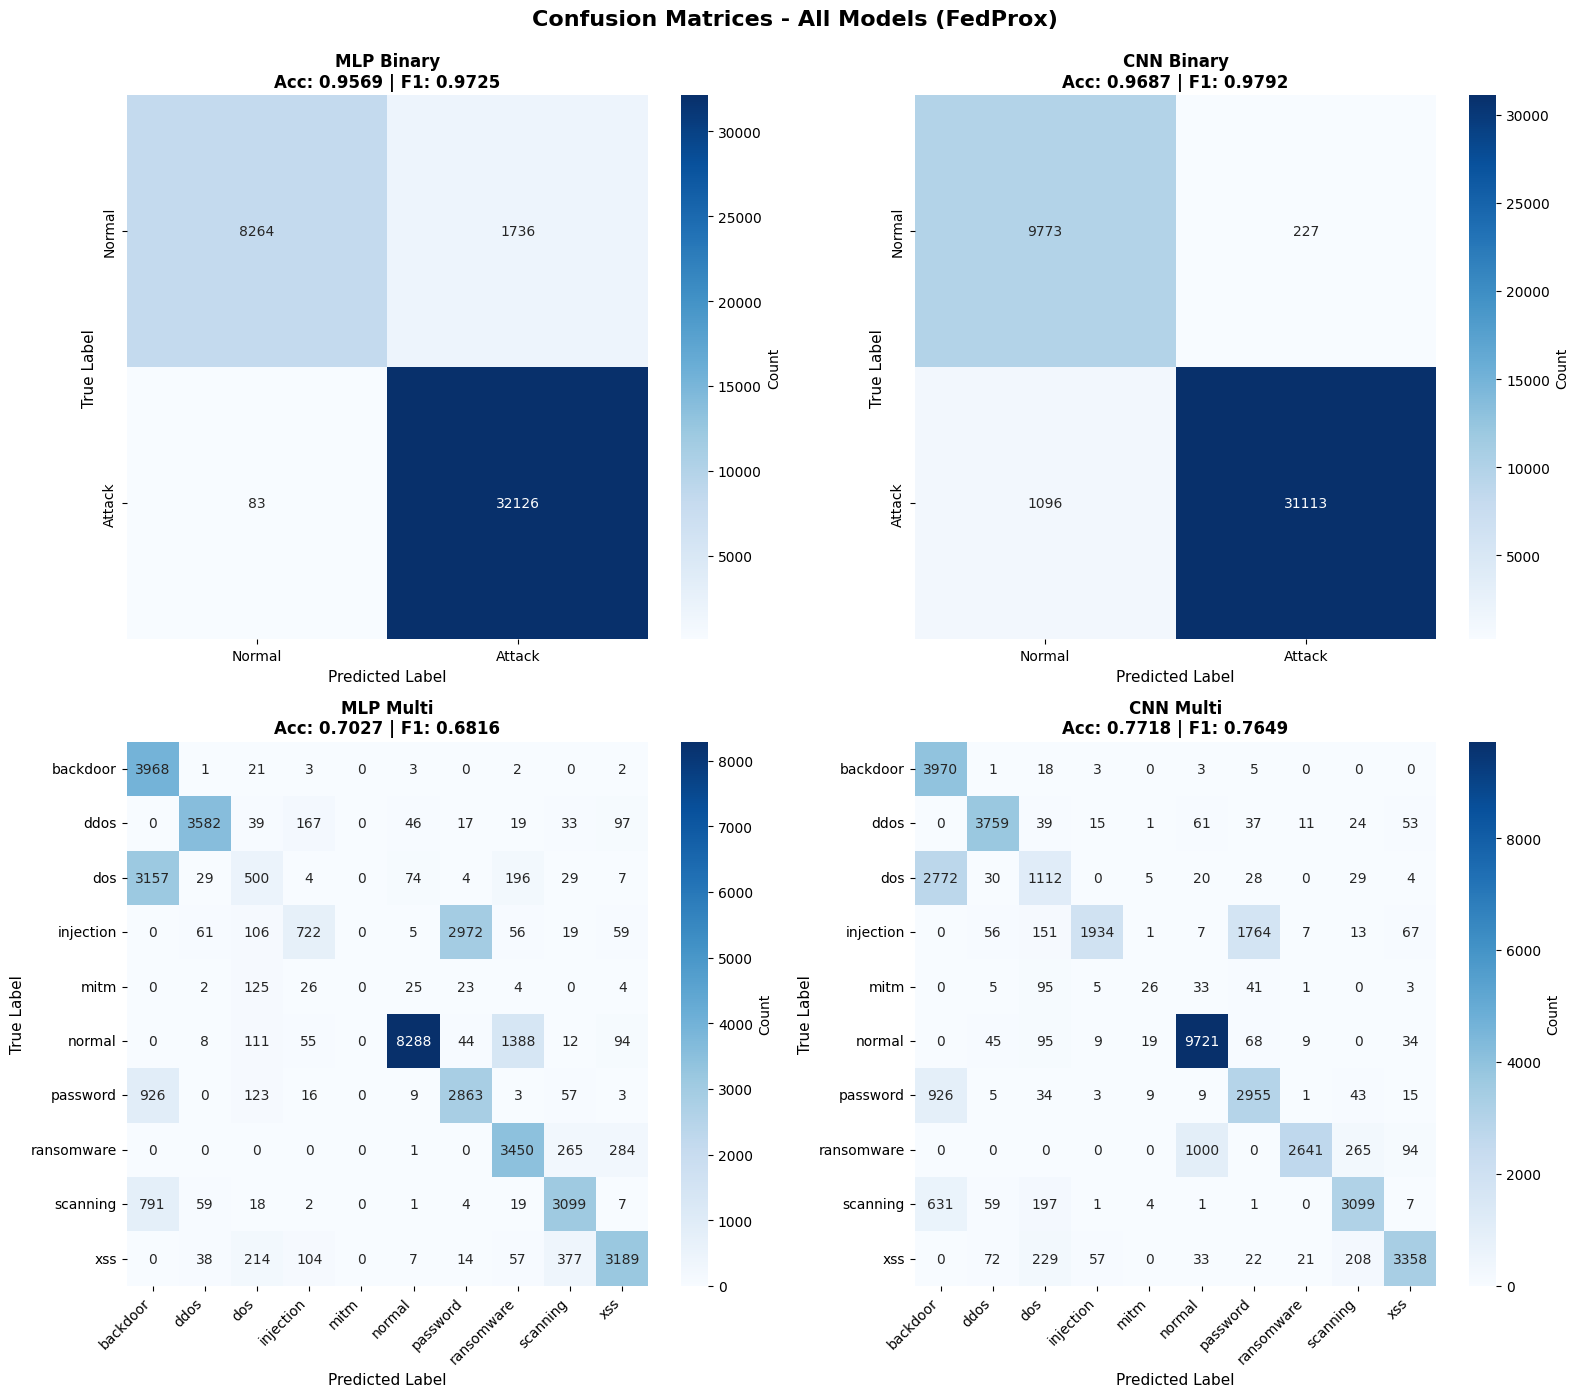


PER-CLASS PERFORMANCE ANALYSIS (Multi-class Models)

MLP Multi:
+------------+-------------+----------+------------+-----------+
| Class      |   Precision |   Recall |   F1-Score | Support   |
+============+=============+==========+============+===========+
| backdoor   |      0.4488 |   0.992  |     0.618  | 4,000     |
+------------+-------------+----------+------------+-----------+
| ddos       |      0.9476 |   0.8955 |     0.9208 | 4,000     |
+------------+-------------+----------+------------+-----------+
| dos        |      0.3978 |   0.125  |     0.1902 | 4,000     |
+------------+-------------+----------+------------+-----------+
| injection  |      0.657  |   0.1805 |     0.2832 | 4,000     |
+------------+-------------+----------+------------+-----------+
| mitm       |      0      |   0      |     0      | 209       |
+------------+-------------+----------+------------+-----------+
| normal     |      0.9798 |   0.8288 |     0.898  | 10,000    |
+------------+-----------

/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elnoersan/Skripsi/Paper/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [14]:
print("="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

# Create figure with 2x2 subplots for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrices - All Models (FedProx)', fontsize=16, fontweight='bold', y=0.995)

model_configs = [
    ('MLP Binary', 'mlp_binary', y_test_bin, ['Normal', 'Attack'], axes[0, 0]),
    ('CNN Binary', 'cnn_binary', y_test_bin, ['Normal', 'Attack'], axes[0, 1]),
    ('MLP Multi', 'mlp_multi', y_test_multi, le_target.classes_, axes[1, 0]),
    ('CNN Multi', 'cnn_multi', y_test_multi, le_target.classes_, axes[1, 1])
]

for model_name, model_key, y_true, labels, ax in model_configs:
    # Get predictions
    y_pred = all_metrics[model_name]['predictions']
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    
    # Add metrics to title
    acc = all_metrics[model_name]['accuracy']
    f1 = all_metrics[model_name]['f1_score']
    ax.set_title(f'{model_name}\nAcc: {acc:.4f} | F1: {f1:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    # Rotate labels for multi-class
    if 'Multi' in model_name:
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('fedprox_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrices saved as 'fedprox_confusion_matrices.png'")
plt.show()

# Print detailed metrics per class for multi-class models
print("\n" + "="*70)
print("PER-CLASS PERFORMANCE ANALYSIS (Multi-class Models)")
print("="*70)

for model_name in ['MLP Multi', 'CNN Multi']:
    print(f"\n{model_name}:")
    y_pred = all_metrics[model_name]['predictions']
    
    # Classification report
    from sklearn.metrics import classification_report
    report = classification_report(y_test_multi, y_pred, 
                                   target_names=le_target.classes_,
                                   output_dict=True)
    
    # Build table
    rows = []
    for class_name in le_target.classes_:
        if class_name in report:
            rows.append([
                class_name,
                f"{report[class_name]['precision']:.4f}",
                f"{report[class_name]['recall']:.4f}",
                f"{report[class_name]['f1-score']:.4f}",
                f"{int(report[class_name]['support']):,}"
            ])
    
    print(tabulate(rows, 
                   headers=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'],
                   tablefmt='grid'))

print("\n" + "="*70)

## BAGIAN 9: VISUALISASI HASIL FEDPROX


VISUALISASI HASIL FLOWER FEDPROX

Visualisasi disimpan sebagai 'fedprox_comprehensive_results.png'


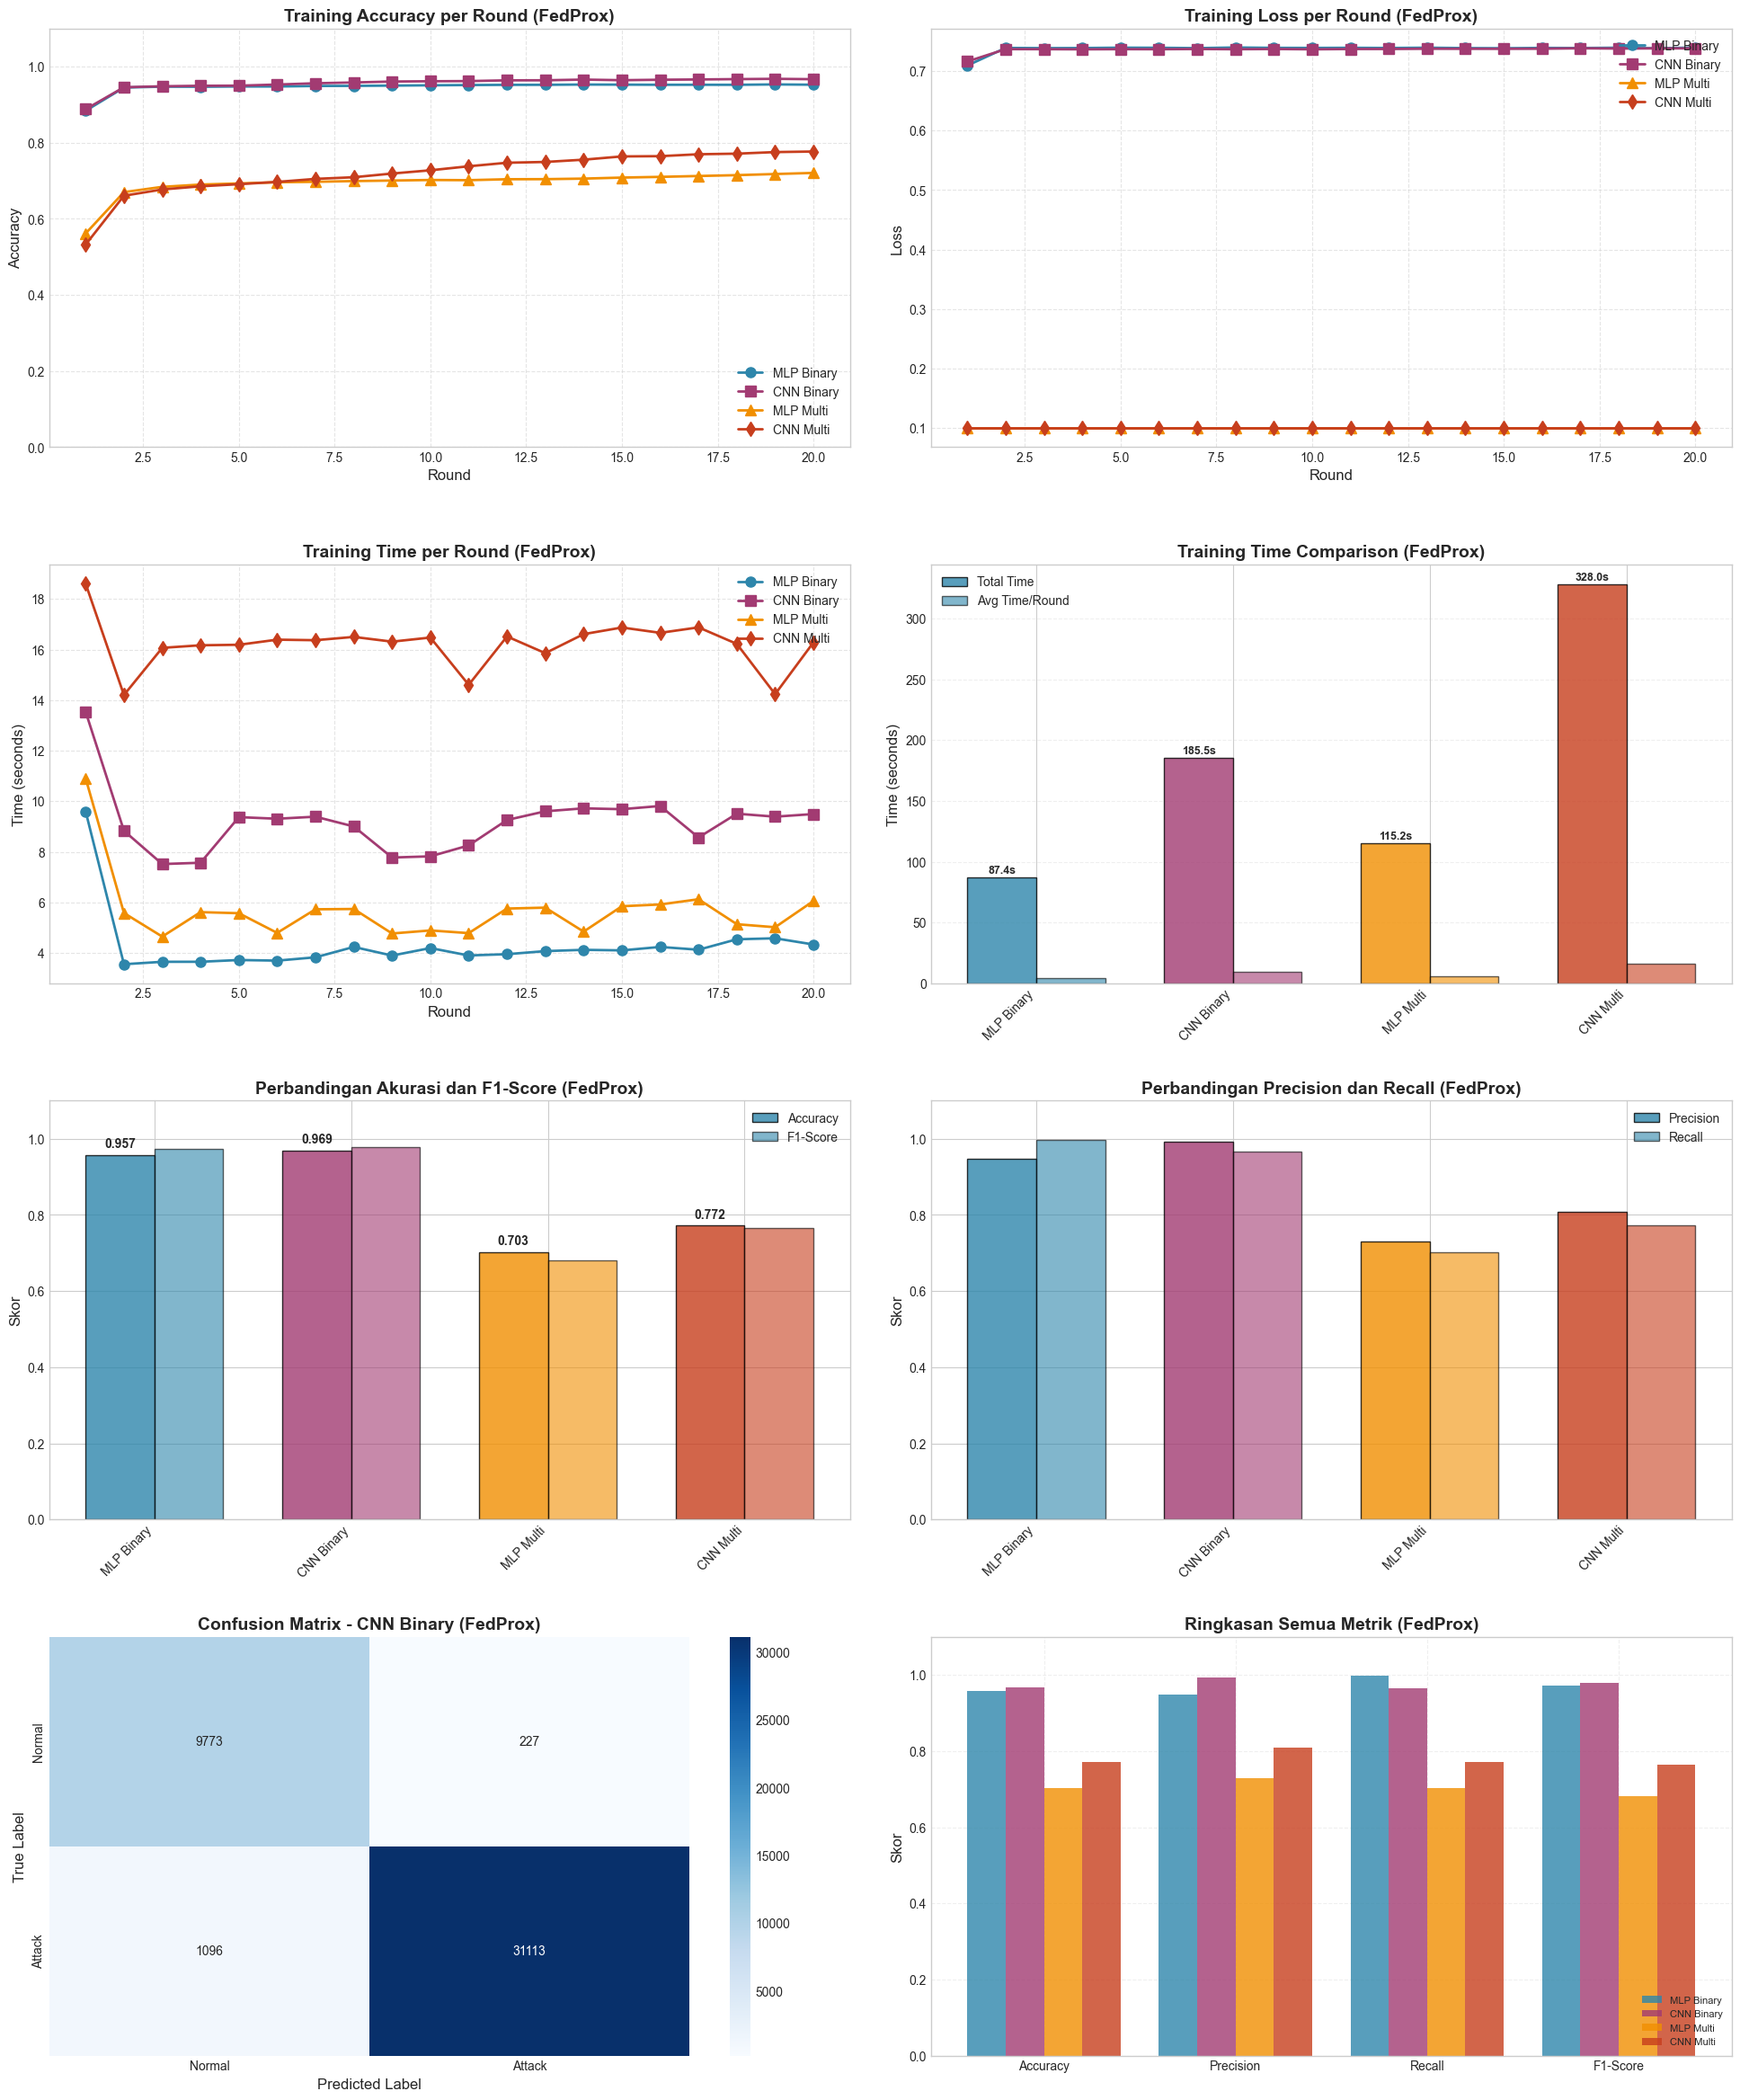

In [15]:
print("\n" + "="*70)
print("VISUALISASI HASIL FLOWER FEDPROX")
print("="*70)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

model_names = ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']
model_keys = ['mlp_binary', 'cnn_binary', 'mlp_multi', 'cnn_multi']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'd']

# Plot 1: Training Accuracy per Round
axes[0, 0].set_title('Training Accuracy per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_accuracy']:
        rounds = list(range(1, len(all_histories[key]['train_accuracy']) + 1))
        axes[0, 0].plot(rounds, all_histories[key]['train_accuracy'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 0].set_xlabel('Round', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(loc='lower right', fontsize=10)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].set_ylim(0, 1.1)

# Plot 2: Training Loss per Round
axes[0, 1].set_title('Training Loss per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['train_loss']:
        rounds = list(range(1, len(all_histories[key]['train_loss']) + 1))
        axes[0, 1].plot(rounds, all_histories[key]['train_loss'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[0, 1].set_xlabel('Round', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(loc='upper right', fontsize=10)
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 3: Round Time per Round
axes[1, 0].set_title('Training Time per Round (FedProx)', fontsize=14, fontweight='bold')
for i, (name, key) in enumerate(zip(model_names, model_keys)):
    if all_histories[key]['round_time']:
        rounds = list(range(1, len(all_histories[key]['round_time']) + 1))
        axes[1, 0].plot(rounds, all_histories[key]['round_time'], 
                       label=name, marker=markers[i], color=colors[i], 
                       linewidth=2, markersize=8)

axes[1, 0].set_xlabel('Round', fontsize=12)
axes[1, 0].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 0].legend(loc='upper right', fontsize=10)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Total Training Time Comparison
total_times = [all_histories[key]['total_time'] for key in model_keys]
avg_round_times = [np.mean(all_histories[key]['round_time']) for key in model_keys]

x_pos = np.arange(len(model_names))
width = 0.35

bars_total = axes[1, 1].bar(x_pos - width/2, total_times, width, label='Total Time', 
                            color=colors, alpha=0.8, edgecolor='black')
bars_avg = axes[1, 1].bar(x_pos + width/2, avg_round_times, width, label='Avg Time/Round', 
                          color=colors, alpha=0.6, edgecolor='black')

axes[1, 1].set_title('Training Time Comparison (FedProx)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.3, axis='y')

for bar, t_time in zip(bars_total, total_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_times)*0.01, 
                    f'{t_time:.1f}s', ha='center', fontsize=9, fontweight='bold')

# Plot 5: Accuracy Comparison
accuracies = [all_metrics[name]['accuracy'] for name in model_names]
f1_scores = [all_metrics[name]['f1_score'] for name in model_names]

bars1 = axes[2, 0].bar(x_pos - width/2, accuracies, width, label='Accuracy', 
                       color=colors, alpha=0.8, edgecolor='black')
bars2 = axes[2, 0].bar(x_pos + width/2, f1_scores, width, label='F1-Score', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 0].set_title('Perbandingan Akurasi dan F1-Score (FedProx)', fontsize=14, fontweight='bold')
axes[2, 0].set_ylabel('Skor', fontsize=12)
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 0].legend()
axes[2, 0].set_ylim(0, 1.1)

for bar, acc in zip(bars1, accuracies):
    axes[2, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{acc:.3f}', ha='center', fontweight='bold', fontsize=10)

# Plot 6: Precision vs Recall
precisions = [all_metrics[name]['precision'] for name in model_names]
recalls = [all_metrics[name]['recall'] for name in model_names]

bars3 = axes[2, 1].bar(x_pos - width/2, precisions, width, label='Precision', 
                       color=colors, alpha=0.8, edgecolor='black')
bars4 = axes[2, 1].bar(x_pos + width/2, recalls, width, label='Recall', 
                       color=colors, alpha=0.6, edgecolor='black')

axes[2, 1].set_title('Perbandingan Precision dan Recall (FedProx)', fontsize=14, fontweight='bold')
axes[2, 1].set_ylabel('Skor', fontsize=12)
axes[2, 1].set_xticks(x_pos)
axes[2, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[2, 1].legend()
axes[2, 1].set_ylim(0, 1.1)

# Plot 7: Confusion Matrix for Best Binary Model
best_binary = 'MLP Binary' if all_metrics['MLP Binary']['f1_score'] > all_metrics['CNN Binary']['f1_score'] else 'CNN Binary'
y_pred_best = all_metrics[best_binary]['predictions']
cm = confusion_matrix(y_test_bin, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[3, 0],
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
axes[3, 0].set_title(f'Confusion Matrix - {best_binary} (FedProx)', fontsize=14, fontweight='bold')
axes[3, 0].set_ylabel('True Label', fontsize=12)
axes[3, 0].set_xlabel('Predicted Label', fontsize=12)

# Plot 8: Model Comparison Summary
metrics_data = []
for name in model_names:
    metrics_data.append([
        all_metrics[name]['accuracy'],
        all_metrics[name]['precision'],
        all_metrics[name]['recall'],
        all_metrics[name]['f1_score']
    ])

x_metrics = np.arange(4)
bar_width = 0.2

for i, (name, data) in enumerate(zip(model_names, metrics_data)):
    axes[3, 1].bar(x_metrics + i*bar_width, data, bar_width, 
                   label=name, color=colors[i], alpha=0.8)

axes[3, 1].set_title('Ringkasan Semua Metrik (FedProx)', fontsize=14, fontweight='bold')
axes[3, 1].set_ylabel('Skor', fontsize=12)
axes[3, 1].set_xticks(x_metrics + bar_width * 1.5)
axes[3, 1].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
axes[3, 1].legend(loc='lower right', fontsize=8)
axes[3, 1].set_ylim(0, 1.1)
axes[3, 1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.savefig('fedprox_comprehensive_results.png', dpi=300, bbox_inches='tight')
print("\nVisualisasi disimpan sebagai 'fedprox_comprehensive_results.png'")
plt.show()

## BAGIAN 10: LAPORAN AKHIR FEDPROX

In [16]:
print("\n" + "="*80)
print("LAPORAN AKHIR - FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER")
print("="*80)

print(f"\nINFORMASI EKSPERIMEN:")
print(f"   - Framework: {FRAMEWORK}")
print(f"   - Algoritma: {ALGORITHM}")
print(f"   - Proximal Term (mu) - Binary: {MU_BINARY}, Multi-class: {MU_MULTI}")
print(f"   - Jumlah Klien: {NUM_CLIENTS}")
print(f"   - Distribusi Data: {DATA_DISTRIBUTION}")
print(f"   - Alpha Binary: {ALPHA_BINARY} | Alpha Multi-class: {ALPHA_MULTI}")
print(f"   - Putaran Komunikasi: {NUM_ROUNDS}")
print(f"   - Local Epochs: {LOCAL_EPOCHS}")
print(f"   - Batch Size - Binary: {BATCH_SIZE_BINARY} | Multi-class: {BATCH_SIZE_MULTI}")
print(f"   - Learning Rate: {LEARNING_RATE}")
#print(f"   - Ukuran Dataset: {df.shape[0]:,} sampel")
print(f"   - Preprocessing: Smart protocol-aware preprocessing")
print(f"   - NO SMOTE: Natural class distribution preserved")

print(f"\nDISTRIBUSI DATA KE KLIEN:")
for i, (X_client, y_client) in enumerate(client_data_binary):
    print(f"   - Klien {i+1} (Binary): {len(X_client):,} sampel")

print(f"\nWAKTU PELATIHAN:")
model_names_keys = [
    ('MLP Binary', 'mlp_binary'),
    ('CNN Binary', 'cnn_binary'),
    ('MLP Multi', 'mlp_multi'),
    ('CNN Multi', 'cnn_multi')
]
total_training_time = sum(all_histories[key]['total_time'] for _, key in model_names_keys)

for name, key in model_names_keys:
    history = all_histories[key]
    print(f"   - {name}:")
    print(f"      - Total: {history['total_time']:.2f}s")
    print(f"      - Per Round (avg): {np.mean(history['round_time']):.2f}s")
    print(f"      - Per Round (min/max): {np.min(history['round_time']):.2f}s / {np.max(history['round_time']):.2f}s")

print(f"\n   - Total Waktu Pelatihan Semua Model: {total_training_time:.2f}s ({total_training_time/60:.2f} menit)")

print(f"\nMODEL TERBAIK:")
best_binary = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Binary' in name],
    key=lambda x: x[1]['f1_score']
)
best_multi = max(
    [(name, metrics) for name, metrics in all_metrics.items() if 'Multi' in name],
    key=lambda x: x[1]['f1_score']
)

print(f"   Klasifikasi Binary:")
print(f"      - Terbaik: {best_binary[0]}")
print(f"      - Accuracy: {best_binary[1]['accuracy']:.4f}")
print(f"      - Precision: {best_binary[1]['precision']:.4f}")
print(f"      - Recall: {best_binary[1]['recall']:.4f}")
print(f"      - F1-Score: {best_binary[1]['f1_score']:.4f}")

print(f"\n   Klasifikasi Multi-class:")
print(f"      - Terbaik: {best_multi[0]}")
print(f"      - Accuracy: {best_multi[1]['accuracy']:.4f}")
print(f"      - Precision: {best_multi[1]['precision']:.4f}")
print(f"      - Recall: {best_multi[1]['recall']:.4f}")
print(f"      - F1-Score: {best_multi[1]['f1_score']:.4f}")

print(f"\nRINGKASAN PERFORMA SEMUA MODEL:")
for name in ['MLP Binary', 'CNN Binary', 'MLP Multi', 'CNN Multi']:
    metrics = all_metrics[name]
    print(f"   - {name}:")
    print(f"      - Accuracy: {metrics['accuracy']:.4f}")
    print(f"      - Precision: {metrics['precision']:.4f}")
    print(f"      - Recall: {metrics['recall']:.4f}")
    print(f"      - F1-Score: {metrics['f1_score']:.4f}")

print(f"\nKESIMPULAN:")
print(f"   - FedProx berhasil melatih {len(all_models)} model pada lingkungan Non-IID")
print(f"   - Proximal term (mu= Binary {MU_BINARY}, Multi {MU_MULTI}) membantu konvergensi pada data heterogen")
print(f"   - FedProx lebih stabil dibandingkan FedAvg pada data yang sangat Non-IID")
print(f"   - Smart preprocessing menjaga semantic meaning protocol-specific features")
print(f"   - Natural class distribution (tanpa SMOTE) lebih realistis untuk FL")

print(f"\nKEUNGGULAN FEDPROX:")
print(f"   - Convergence lebih stabil pada data Non-IID")
print(f"   - Mengatasi system heterogeneity (klien dengan kemampuan berbeda)")
print(f"   - Proximal term mencegah model lokal terlalu jauh dari global")
print(f"   - Hyperparameter mu dapat disesuaikan untuk berbagai skenario")
print(f"   - Implementasi sederhana dengan Flower framework")

print(f"\nPARAMETER FEDPROX:")
print(f"   - mu (mu) Binary = {MU_BINARY}: Proximal term untuk binary models")
print(f"   - mu (mu) Multi = {MU_MULTI}: Proximal term untuk multi-class")
print(f"   - Proximal term: (mu/2)||w - w_global||^2")
print(f"   - Lower mu for multi-class allows more local learning on imbalanced data")
print(f"   - Aggregation: Weighted averaging (sama dengan FedAvg)")
print(f"   - Training: Local loss + proximal term")

print(f"\nPREPROCESSING STRATEGY:")
print(f"   - Smart protocol-aware preprocessing")
print(f"   - Context-aware missing value handling")
print(f"   - Protocol indicators: has_dns, has_http, has_ssl")
print(f"   - Feature engineering: bytes_ratio, pkts_ratio, rate features")
print(f"   - Pipeline: Split -> RFE -> Scale (no data leakage)")
print(f"   - NO SMOTE: Preserves natural Non-IID characteristics")

print("\nEKSPERIMEN FEDPROX SELESAI")
print("="*80)


LAPORAN AKHIR - FEDERATED PROXIMAL (FEDPROX) DENGAN FLOWER

INFORMASI EKSPERIMEN:
   - Framework: Flower (flwr)
   - Algoritma: Federated Proximal (FedProx)
   - Proximal Term (mu) - Binary: 0.01, Multi-class: 0.01
   - Jumlah Klien: 5
   - Distribusi Data: Non-IID (Dirichlet) - Natural Imbalance
   - Alpha Binary: 5 | Alpha Multi-class: 5
   - Putaran Komunikasi: 20
   - Local Epochs: 1
   - Batch Size - Binary: 512 | Multi-class: 512
   - Learning Rate: 0.0005
   - Preprocessing: Smart protocol-aware preprocessing
   - NO SMOTE: Natural class distribution preserved

DISTRIBUSI DATA KE KLIEN:
   - Klien 1 (Binary): 18,363 sampel
   - Klien 2 (Binary): 52,347 sampel
   - Klien 3 (Binary): 42,125 sampel
   - Klien 4 (Binary): 34,395 sampel
   - Klien 5 (Binary): 21,604 sampel

WAKTU PELATIHAN:
   - MLP Binary:
      - Total: 87.38s
      - Per Round (avg): 4.30s
      - Per Round (min/max): 3.55s / 9.60s
   - CNN Binary:
      - Total: 185.51s
      - Per Round (avg): 9.17s
      - Per